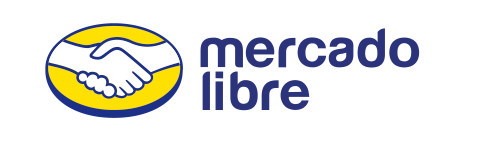

#**Challenge de Mercado Libre**

En el siguiente script se presentará la solución al caso de Mercado Libre referente al tema:

*El equipo comercial quiere realizar estrategias focalizadas para los sellers, pero en este momento no existe una clasificación que permita identificar a aquellos que tienen un buen perfil y son relevantes para el negocio. ¿Cómo podrías ayudar al equipo comercial a identificar estos sellers?*

Se aclara que la solución al problema se plantea para Colombia, sin embargo, la metodología sería similar para el resto de países de la compañía.


# **Librerías**

Se mencionan las librerías que serán usadas en el siguiente Notebook

A continuación se presentan las librerías empleadas para la realización del caso de Mercado Libre. Para cada librería usada se explica el funcionamiento de la misma en el problema planteado.

In [3]:
!pip install fuzzy-c-means

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: typer
    Found existing installation: typer 0.7.0
    Uninstalling typer-0.7.0:
      Successfully uninstalled typer-0.7.0


In [4]:
#Librerías normales data science
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date
from datetime import timedelta

#Librerias para extracción de la data del API
import requests
import json

#Cambiar algunos valores nulos
from sklearn.impute import SimpleImputer

#Gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#Estandarización de la data
from sklearn.preprocessing import StandardScaler

#Modelamiento
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from fcmeans import FCM
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# **Lectura de la data**

Aquí se presenta la información de lectura desde el API de Mercado Libre

En la siguiente línea se realiza la obtención de las categorías que tiene Mercado Libre Colombia 

In [ ]:
cats = requests.get('https://api.mercadolibre.com/sites/MCO/categories')
cats.json()
df_categorias = pd.DataFrame(cats.json())
df_categorias.head()

,id,name
0,MCO1747,Accesorios para Vehículos
1,MCO441917,Agro
2,MCO1403,Alimentos y Bebidas
3,MCO1071,Animales y Mascotas
4,MCO1367,Antigüedades y Colecciones


In [ ]:
df_consolidado = pd.DataFrame(columns=['site_id', 'results'])
for cat_id in df_categorias['id']:
  for offset in list(range(0, 1000, 50)):
    url = f'https://api.mercadolibre.com/sites/MCO/search?category={cat_id}&offset={offset}'
    request = requests.get(url)
    items = request.json() #Traer información del JSON
    max_length = max(len(arr) if isinstance(arr, list) else 1 for arr in items.values()) #Se busca máximo para que poder generar data Frame con esta longitud
    data_con_NaN = {key: arr + [np.nan] * (max_length - (len(arr) if isinstance(arr, list) else 1)) if isinstance(arr, list) else [arr] * max_length for key, arr in items.items()} #Rellenar con Nulos
    df_unir = pd.DataFrame(data_con_NaN)
    try:
      df_unir = df_unir[['site_id', 'results']]
    except:
      print(offset)
      print(df_unir)
      break
    df_consolidado = pd.concat([df_consolidado, df_unir], axis=0, ignore_index=True) #df_consolidado.append(df_unir, ignore_index=True)

df_consolidado

,site_id,results
0,MCO,"{'id': 'MCO464124554', 'title': 'Combo 2 Forro..."
1,MCO,"{'id': 'MCO1155622578', 'title': 'Casco Integr..."
2,MCO,"{'id': 'MCO547297635', 'title': 'Espejo Retrov..."
3,MCO,"{'id': 'MCO635353443', 'title': 'Sensores De R..."
4,MCO,"{'id': 'MCO446651424', 'title': 'Candado Freno..."
...,...,...
31458,MCO,"{'id': 'MCO880318385', 'title': 'Dabber Arms M..."
31459,MCO,"{'id': 'MCO596059395', 'title': 'Pipas Para Fu..."
31460,MCO,"{'id': 'MCO599435426', 'title': 'Pipa De Agua ..."
31461,MCO,"{'id': 'MCO1057807949', 'title': 'Cíngulo Litú..."


En la siguente línea se presenta la extracción de la data del API de Mercado Libre, se aclara que del archivo JSON únicamente se extrajo la información de "resultus" ya que el resto de información no fue considerada relevante para la solución del problema. 

Por otro lado, de todas las opciones que se tenían dentro del archivo JSON filtrado con results únicamente se seleccionaron las columnas que se mencionan abajo, luego de una revisión de las mismas.

In [ ]:
columnas = ['seller.id','category_id', 'domain_id', 'price', 'original_price', 'sold_quantity', 'available_quantity', 'shipping.logistic_type', 'shipping.tags', 'seller.registration_date',
            'seller.seller_reputation.level_id', 'seller.seller_reputation.power_seller_status', 'seller.seller_reputation.transactions.canceled', 'seller.seller_reputation.transactions.completed',
            'seller.seller_reputation.transactions.ratings.negative', 'seller.seller_reputation.transactions.ratings.neutral', 'seller.seller_reputation.transactions.ratings.positive',
            'seller.seller_reputation.transactions.total', 'seller.seller_reputation.metrics.sales.completed', 'seller.seller_reputation.metrics.claims.rate',
            'seller.seller_reputation.metrics.claims.value', 'seller.seller_reputation.metrics.delayed_handling_time.rate', 'seller.seller_reputation.metrics.delayed_handling_time.value',
            'seller.seller_reputation.metrics.cancellations.rate', 'seller.seller_reputation.metrics.cancellations.value', 'seller.eshop.eshop_status_id', 'seller_address.state.id']
cont=0
df_consolidado_f = pd.DataFrame(columns=columnas)
for cat_id in df_categorias['id']:
  print('iter', cont,': ', cat_id)
  cont=cont+1
  if cat_id != 'MCO1743' and cat_id != 'MCO40433' and cat_id != 'MCO1459' and cat_id != 'MCO1540':
    for offset in list(range(0, 1000, 50)):
      url = f'https://api.mercadolibre.com/sites/MCO/search?category={cat_id}&offset={offset}'
      request = requests.get(url)
      items = request.json() #Traer información del JSON
      df_unir = pd.json_normalize(items['results'])
      df_unir = df_unir[columnas]
      df_consolidado_f = pd.concat([df_consolidado_f, df_unir], axis=0, ignore_index=True) 

df_consolidado_f

iter 0 :  MCO1747
iter 1 :  MCO441917
iter 2 :  MCO1403
iter 3 :  MCO1071
iter 4 :  MCO1367
iter 5 :  MCO1368
iter 6 :  MCO1384
iter 7 :  MCO1246
iter 8 :  MCO40433
iter 9 :  MCO1039
iter 10 :  MCO1743
iter 11 :  MCO1051
iter 12 :  MCO1648
iter 13 :  MCO1144
iter 14 :  MCO172890
iter 15 :  MCO1276
iter 16 :  MCO5726
iter 17 :  MCO1000
iter 18 :  MCO175794
iter 19 :  MCO1574
iter 20 :  MCO1499
iter 21 :  MCO1459
iter 22 :  MCO1182
iter 23 :  MCO1132
iter 24 :  MCO3025
iter 25 :  MCO1168
iter 26 :  MCO118204
iter 27 :  MCO3937
iter 28 :  MCO1430
iter 29 :  MCO180800
iter 30 :  MCO1540
iter 31 :  MCO1953


,seller.id,category_id,domain_id,price,original_price,sold_quantity,available_quantity,shipping.logistic_type,shipping.tags,seller.registration_date,...,seller.seller_reputation.transactions.total,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.eshop.eshop_status_id,seller_address.state.id
0,152737872,MCO178000,MCO-CAR_SEAT_COVERS,63053,NaN,500,1,fulfillment,"[fulfillment, self_service_in]",2014-01-21T18:28:42.000-04:00,...,6130,818,0.0023,2,0.0000,0,0.0000,0,1.0,CO-DC
1,187465913,MCO21947,MCO-MOTORCYCLE_HELMETS,148941,161892.0,5,50,xd_drop_off,"[self_service_in, mandatory_free_shipping]",2015-07-10T18:56:11.000-04:00,...,3234,740,0.0077,6,0.0843,57,0.0000,0,1.0,CO-ANT
2,145181776,MCO174843,MCO-LIGHT_VEHICLE_PARTS,13000,NaN,500,1,fulfillment,"[fulfillment, self_service_out]",2013-09-04T10:50:11.000-04:00,...,14880,1816,0.0016,3,0.0000,0,0.0000,0,1.0,CO-ANT
3,212962423,MCO173820,MCO-VEHICLE_PARKING_SENSORS,39000,78000.0,500,500,drop_off,[],2016-05-02T23:39:21.000-04:00,...,30985,6012,0.0020,13,0.0091,56,0.0020,13,NaN,CO-QUI
4,61678362,MCO90072,MCO-BICYCLE_AND_MOTORCYCLE_ALARMS,41900,54900.0,500,1,cross_docking,[self_service_in],2004-04-27T14:29:33.000-04:00,...,50344,8425,0.0052,45,0.0163,137,0.0003,3,2.0,CO-DC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27970,311316105,MCO442293,MCO-ENERGETIC_STONES,19999,NaN,5,1,fulfillment,"[fulfillment, self_service_in]",2018-03-29T22:17:32.000-04:00,...,1866,200,0.0092,2,0.0096,2,0.0046,1,NaN,CO-ANT
27971,13859533,MCO442272,MCO-TOBACCO_PIPES,22900,NaN,5,1,xd_drop_off,[self_service_in],2007-04-09T09:48:02.000-04:00,...,363,352,0.0027,1,0.0028,1,0.0000,0,2.0,CO-DC
27972,682270333,MCO417908,MCO-BONGS,14990,NaN,5,1,xd_drop_off,[self_service_in],2020-12-03T18:47:28.000-04:00,...,2765,365,0.0026,1,0.0193,7,0.0000,0,NaN,CO-CUN
27973,68875125,MCO417908,MCO-BONGS,17000,NaN,5,1,drop_off,[],2009-03-20T02:52:06.000-04:00,...,1681,150,0.0064,1,0.0000,0,0.0000,0,NaN,CO-ANT


# **Pre-Procesamiento de la data**

La información que sale en la siguiente sección corresponde a las transformaciones de las variables para poder realizar los siguientes análisis

## *Transformación de tipo de variables*

A continuación se procede a observar los tipos de variables que trae la base de datos y cómo pasarlo a los tipos de datos correctos

Se observan los tipos de variable que tiene cada categoría

In [ ]:
df_consolidado_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27983 entries, 0 to 27982
Data columns (total 27 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   seller.id                                                     27983 non-null  int64  
 1   category_id                                                   27983 non-null  object 
 2   domain_id                                                     27983 non-null  object 
 3   price                                                         27983 non-null  int64  
 4   original_price                                                4497 non-null   float64
 5   sold_quantity                                                 27983 non-null  int64  
 6   available_quantity                                            27983 non-null  int64  
 7   shipping.logistic_type                                        27983

Se procede a realizar los cambios a las variables con categoría errónea

In [ ]:
import datetime
df_consolidado_f['seller.id'] = df_consolidado_f['seller.id'].astype(str)
df_consolidado_f['price'] = df_consolidado_f['price'].astype(float)
df_consolidado_f['original_price'] = df_consolidado_f['original_price'].astype(float)
df_consolidado_f['seller.eshop.eshop_status_id'] = df_consolidado_f['seller.eshop.eshop_status_id'].astype(str)
df_consolidado_f['seller.registration_date'] = pd.to_datetime(df_consolidado_f['seller.registration_date'])

Se revisa los tipos de variables después de transformadas

In [ ]:
df_consolidado_f.dtypes

seller.id                                                                                       object
category_id                                                                                     object
domain_id                                                                                       object
price                                                                                          float64
original_price                                                                                 float64
sold_quantity                                                                                    int64
available_quantity                                                                               int64
shipping.logistic_type                                                                          object
shipping.tags                                                                                   object
seller.registration_date                                        datetime6

## *Transformación de variables*

A continuación se procede a transformar algunas variables para explicar de mejor forma el contexto del problema a resolver

In [ ]:
df_consolidado_f['Dias_Usuario'] = (date.today() - df_consolidado_f['seller.registration_date'].dt.date).dt.days #Se genera la cantidad de días que la persona ha estado en la empresa
df_consolidado_f['Utilidad_Generada'] = df_consolidado_f['price'] * df_consolidado_f['sold_quantity']
df_consolidado_f

,seller.id,category_id,domain_id,price,original_price,sold_quantity,available_quantity,shipping.logistic_type,shipping.tags,seller.registration_date,...,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.eshop.eshop_status_id,seller_address.state.id,Dias_Usuario,Utilidad_Generada
0,152737872,MCO178000,MCO-CAR_SEAT_COVERS,59900.0,63053.0,500,1,fulfillment,"['fulfillment', 'self_service_in']",2014-01-21 18:28:42-04:00,...,0.0023,2,0.0000,0,0.0000,0,1.0,CO-DC,3420,29950000.0
1,187465913,MCO21947,MCO-MOTORCYCLE_HELMETS,148941.0,161892.0,5,50,xd_drop_off,"['self_service_in', 'mandatory_free_shipping']",2015-07-10 18:56:11-04:00,...,0.0077,6,0.0843,57,0.0000,0,1.0,CO-ANT,2885,744705.0
2,145181776,MCO174843,MCO-LIGHT_VEHICLE_PARTS,13000.0,NaN,500,1,fulfillment,"['fulfillment', 'self_service_out']",2013-09-04 10:50:11-04:00,...,0.0016,3,0.0000,0,0.0000,0,1.0,CO-ANT,3559,6500000.0
3,212962423,MCO173820,MCO-VEHICLE_PARKING_SENSORS,39000.0,78000.0,500,500,drop_off,[],2016-05-02 23:39:21-04:00,...,0.0019,12,0.0094,56,0.0021,13,nan,CO-QUI,2588,19500000.0
4,216893546,MCO90075,MCO-MOTORCYCLE_RAIN_SUITS,30900.0,NaN,5000,100,fulfillment,['fulfillment'],2016-06-11 18:23:47-04:00,...,0.0027,9,0.0015,5,0.0000,0,1.0,CO-TOL,2548,154500000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27978,36413721,MCO3530,MCO-UNCLASSIFIED_PRODUCTS,22900.0,NaN,5,1,custom,[],2010-10-31 22:03:09-04:00,...,0.0000,0,0.0000,0,0.0000,0,2.0,CO-VAC,4598,114500.0
27979,63241146,MCO412101,MCO-TEMPORARY_TATTOOS,49900.0,NaN,5,1,cross_docking,['self_service_in'],2009-01-18 12:35:08-04:00,...,0.0081,7,0.0048,4,0.0011,1,1.0,CO-ANT,5249,249500.0
27980,178626427,MCO116987,MCO-ESOTERIC_PRODUCTS,34900.0,NaN,25,1,xd_drop_off,['self_service_in'],2015-11-08 23:57:07-04:00,...,0.0113,3,0.0083,2,0.0000,0,1.0,CO-DC,2764,872500.0
27981,145886729,MCO425038,MCO-GIFT_CARDS,112000.0,NaN,25,1,xd_drop_off,"['self_service_in', 'mandatory_free_shipping']",2013-09-16 20:45:10-04:00,...,0.0000,0,0.0000,0,0.0000,0,nan,CO-ANT,3547,2800000.0


## *Eliminación de algunas variables*

Se procede a eliminar variables que se observa no serán relevantes para la solución del problema

In [ ]:
del df_consolidado_f['category_id'], df_consolidado_f['domain_id'], df_consolidado_f['original_price'], df_consolidado_f['shipping.logistic_type'], df_consolidado_f['shipping.tags'], df_consolidado_f['seller.registration_date']

## *Manejo de Nulos*

Primero se observa cuántos valores nulos hay, posteriormente se revisa cómo se imputará cada uno de ellos

In [ ]:
pd.DataFrame(df_consolidado_f.isna().sum()) #Conocer cantidad de nulos

,0
seller.id,0
price,0
sold_quantity,0
available_quantity,0
seller.seller_reputation.level_id,31
seller.seller_reputation.power_seller_status,6175
seller.seller_reputation.transactions.canceled,0
seller.seller_reputation.transactions.completed,0
seller.seller_reputation.transactions.ratings.negative,0
seller.seller_reputation.transactions.ratings.neutral,0


Ahora se observa los tipos de valores únicos que poseen estas variables

In [ ]:
df_consolidado_f['seller.seller_reputation.level_id'].unique()

array(['5_green', '4_light_green', nan, '3_yellow', '2_orange', '1_red'],
      dtype=object)

In [ ]:
df_consolidado_f['seller.seller_reputation.power_seller_status'].unique()

array(['gold', 'platinum', 'silver', nan], dtype=object)

In [ ]:
df_consolidado_f['seller.eshop.eshop_status_id'].unique()

array(['1.0', 'nan', '2.0', '0.0'], dtype=object)

In [ ]:
df_consolidado_f['seller_address.state.id'].unique()

array(['CO-DC', 'CO-ANT', 'CO-QUI', 'CO-TOL', 'CO-CUN', 'CO-VAC',
       'CO-BOY', 'CO-SAN', 'CO-BOL', 'CO-NSA', 'CO-MAG', 'CO-RIS',
       'CO-CAL', 'CO-MET', 'CO-ATL', 'CO-NAR', 'CN-GD', 'CO-HUI',
       'CO-CES', 'CO-CAQ', 'CO-SUC', 'CO-CAU', 'CN-ZJ', 'CN-YN', 'CN-HB',
       'CO-LAG', 'CN-SC', 'CN-CQ', 'US-FL', 'CN-SX', 'CN-HA', 'CO-CAS',
       'CO-COR', 'CO-SAP', 'CN-SH', 'CN-FJ', 'CN-JS', 'CN-BJ', 'CN-SD',
       nan, 'CN-GX', 'US-NY', 'CN-HN', 'CO-ARA', 'CN-TJ', 'CN-NX',
       'HK-HK', 'CN-HI', 'CO-PUT'], dtype=object)

Debido a que según el entendimiento del negocio no es posible sólo imputar la variable que más se repite a cada item, lo que se debe hacer para las tres primeras variables es crear una nueva categoría para incluir allí a las que no están, debido a que son clasificaciones de negocio, no se puede incluir a un seller en alguna de ellas sin una justificación de tal manera.

Sin embargo, para el estado del seller que no aparece se le pondrá el más repetido.

In [ ]:
#Primeras tres variables
df_consolidado_f['seller.seller_reputation.level_id'] = df_consolidado_f['seller.seller_reputation.level_id'].fillna("No_Aplica")
df_consolidado_f['seller.seller_reputation.power_seller_status'] = df_consolidado_f['seller.seller_reputation.power_seller_status'].fillna("No_aplica")
df_consolidado_f['seller.eshop.eshop_status_id'] = df_consolidado_f['seller.eshop.eshop_status_id'].replace('nan', 'No_aplica')

#Variables a las que se les aplicará el valor más repetido
Mas_repetida = df_consolidado_f['seller_address.state.id'].value_counts().idxmax()
df_consolidado_f['seller_address.state.id'] = df_consolidado_f['seller_address.state.id'].fillna(Mas_repetida)

Se revisa nuevamente la cantidad de nulos en el problema

In [ ]:
pd.DataFrame(df_consolidado_f.isna().sum()) #Conocer cantidad de nulos

,0
seller.id,0
price,0
sold_quantity,0
available_quantity,0
seller.seller_reputation.level_id,0
seller.seller_reputation.power_seller_status,0
seller.seller_reputation.transactions.canceled,0
seller.seller_reputation.transactions.completed,0
seller.seller_reputation.transactions.ratings.negative,0
seller.seller_reputation.transactions.ratings.neutral,0


Todas las variables se encuentran sin nulos

## *Agrupar por seller*

A continuación se revisa si se debe agrupar la data para cada vendedor, asumiendo que un vendedor puede vender cualquier tipo de producto en Mercado Libre

In [ ]:
df_consolidado_f=df_consolidado_f.sort_values(by='seller.id',ascending=True)
df_consolidado_f.head(10)

,seller.id,price,sold_quantity,available_quantity,seller.seller_reputation.level_id,seller.seller_reputation.power_seller_status,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.completed,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.neutral,...,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.eshop.eshop_status_id,seller_address.state.id,Dias_Usuario,Utilidad_Generada
9023,1000784474,36277.0,5,1,2_orange,No_aplica,6,53,0.00,0.00,...,0.0677,4,0.0769,4,0.0,0,No_aplica,CO-ANT,597,181385.0
24782,1002392737,75090.0,25,50,5_green,silver,68,1166,0.14,0.02,...,0.0156,4,0.0775,19,0.0,0,No_aplica,CO-CUN,594,1877250.0
23089,1002392737,19900.0,50,1,5_green,silver,68,1166,0.14,0.02,...,0.0156,4,0.0775,19,0.0,0,No_aplica,CO-CUN,594,995000.0
23000,1002392737,23250.0,500,250,5_green,silver,68,1166,0.14,0.02,...,0.0156,4,0.0775,19,0.0,0,No_aplica,CO-CUN,594,11625000.0
24253,1002392737,92000.0,100,100,5_green,silver,68,1166,0.14,0.02,...,0.0156,4,0.0775,19,0.0,0,No_aplica,CO-CUN,594,9200000.0
23142,1002392737,33999.0,50,1,5_green,silver,68,1166,0.14,0.02,...,0.0156,4,0.0775,19,0.0,0,No_aplica,CO-CUN,594,1699950.0
23014,1002392737,22999.0,250,250,5_green,silver,68,1166,0.14,0.02,...,0.0156,4,0.0775,19,0.0,0,No_aplica,CO-CUN,594,5749750.0
23288,1002392737,14000.0,25,50,5_green,silver,68,1166,0.14,0.02,...,0.0156,4,0.0775,19,0.0,0,No_aplica,CO-CUN,594,350000.0
23094,1002392737,17900.0,250,1,5_green,silver,68,1166,0.14,0.02,...,0.0156,4,0.0775,19,0.0,0,No_aplica,CO-CUN,594,4475000.0
24948,1002392737,105000.0,5,1,5_green,silver,68,1166,0.14,0.02,...,0.0156,4,0.0775,19,0.0,0,No_aplica,CO-CUN,594,525000.0


Se observa por el *seller.id* que al menos 1 vendedor tiene más de 1 producto vendiéndose en mercado libre, razón por la cual se procederá a agrupar su información. 

Antes de realizar esta agrupación se procede a eliminar las columnas que no son necesarias para la solución del problema

Una vez realizado esto se procede a crear una nueva columna que indique la cantidad de productos que vende el seller

In [ ]:
df_consolidado_f['Cantidad_Prod_Vendiendo'] = df_consolidado_f.groupby('seller.id')['seller.id'].transform('count')
df_consolidado_f['Sold_qty_tot'] = df_consolidado_f.groupby('seller.id')['sold_quantity'].transform('sum')
df_consolidado_f.head()

,seller.id,price,sold_quantity,available_quantity,seller.seller_reputation.level_id,seller.seller_reputation.power_seller_status,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.completed,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.neutral,...,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,seller.eshop.eshop_status_id,seller_address.state.id,Dias_Usuario,Utilidad_Generada,Cantidad_Prod_Vendiendo,Sold_qty_tot
9023,1000784474,36277.0,5,1,2_orange,No_aplica,6,53,0.00,0.00,...,0.0769,4,0.0,0,No_aplica,CO-ANT,597,181385.0,1,5
24782,1002392737,75090.0,25,50,5_green,silver,68,1166,0.14,0.02,...,0.0775,19,0.0,0,No_aplica,CO-CUN,594,1877250.0,10,1260
23089,1002392737,19900.0,50,1,5_green,silver,68,1166,0.14,0.02,...,0.0775,19,0.0,0,No_aplica,CO-CUN,594,995000.0,10,1260
23000,1002392737,23250.0,500,250,5_green,silver,68,1166,0.14,0.02,...,0.0775,19,0.0,0,No_aplica,CO-CUN,594,11625000.0,10,1260
24253,1002392737,92000.0,100,100,5_green,silver,68,1166,0.14,0.02,...,0.0775,19,0.0,0,No_aplica,CO-CUN,594,9200000.0,10,1260


Una vez se han eliminado las variables que no eran necesarias se procede a realizar el group by total

In [ ]:
df_final = pd.DataFrame(df_consolidado_f.groupby(['seller.id', 'seller.seller_reputation.level_id', 'seller.seller_reputation.power_seller_status', 'seller_address.state.id'])['price', 'sold_quantity', 'Sold_qty_tot', 'available_quantity', 'seller.seller_reputation.transactions.canceled', 'seller.seller_reputation.transactions.completed', 'seller.seller_reputation.transactions.ratings.negative', 'seller.seller_reputation.transactions.ratings.neutral', 'seller.seller_reputation.transactions.ratings.positive', 'seller.seller_reputation.transactions.total', 'seller.seller_reputation.metrics.sales.completed', 'seller.seller_reputation.metrics.claims.rate', 'seller.seller_reputation.metrics.claims.value', 'seller.seller_reputation.metrics.delayed_handling_time.rate', 'seller.seller_reputation.metrics.delayed_handling_time.value', 'seller.seller_reputation.metrics.cancellations.rate', 'seller.seller_reputation.metrics.cancellations.value', 'Dias_Usuario', 'Utilidad_Generada', 'Cantidad_Prod_Vendiendo'].mean())
df_final = df_final.reset_index()
del df_final['sold_quantity'] #Se usará el valor total
df_final

<ipython-input-20-0142e6b43c64>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_final = pd.DataFrame(df_consolidado_f.groupby(['seller.id', 'seller.seller_reputation.level_id', 'seller.seller_reputation.power_seller_status', 'seller_address.state.id'])['price', 'sold_quantity', 'Sold_qty_tot', 'available_quantity', 'seller.seller_reputation.transactions.canceled', 'seller.seller_reputation.transactions.completed', 'seller.seller_reputation.transactions.ratings.negative', 'seller.seller_reputation.transactions.ratings.neutral', 'seller.seller_reputation.transactions.ratings.positive', 'seller.seller_reputation.transactions.total', 'seller.seller_reputation.metrics.sales.completed', 'seller.seller_reputation.metrics.claims.rate', 'seller.seller_reputation.metrics.claims.value', 'seller.seller_reputation.metrics.delayed_handling_time.rate', 'seller.seller_reputation.metrics.delayed_handling_time.value', '

,seller.id,seller.seller_reputation.level_id,seller.seller_reputation.power_seller_status,seller_address.state.id,price,Sold_qty_tot,available_quantity,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.completed,seller.seller_reputation.transactions.ratings.negative,...,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,Dias_Usuario,Utilidad_Generada,Cantidad_Prod_Vendiendo
0,1000784474,2_orange,No_aplica,CO-ANT,36277.000000,5.0,1.000,6.0,53.0,0.00,...,53.0,0.0677,4.0,0.0769,4.0,0.0000,0.0,597.0,1.813850e+05,1.0
1,1002392737,5_green,silver,CO-CUN,42013.800000,1260.0,75.400,68.0,1166.0,0.14,...,245.0,0.0156,4.0,0.0775,19.0,0.0000,0.0,594.0,3.657695e+06,10.0
2,1003817483,5_green,No_aplica,CO-DC,60000.000000,500.0,1.000,13.0,763.0,0.00,...,85.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,591.0,3.000000e+07,1.0
3,1003849078,5_green,silver,CO-DC,35366.875000,660.0,63.375,45.0,1778.0,0.01,...,580.0,0.0033,2.0,0.0017,1.0,0.0000,0.0,591.0,3.225500e+06,8.0
4,1004707587,5_green,No_aplica,CO-DC,658437.500000,14.0,1.000,7.0,304.0,0.00,...,72.0,0.0000,0.0,0.0000,0.0,0.0000,0.0,590.0,2.326188e+06,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4314,9921614,5_green,silver,CO-NSA,44466.666667,355.0,1.000,47.0,1325.0,0.02,...,211.0,0.0045,1.0,0.0108,2.0,0.0045,1.0,7657.0,5.943167e+06,3.0
4315,99314935,5_green,silver,CO-DC,9200.000000,500.0,50.000,117.0,2925.0,0.03,...,214.0,0.0000,0.0,0.0000,0.0,0.0136,3.0,4813.0,4.600000e+06,1.0
4316,99530295,5_green,No_aplica,CO-BOY,90000.000000,250.0,1.000,20.0,524.0,0.00,...,524.0,0.0110,6.0,0.0520,25.0,0.0000,0.0,3223.0,2.250000e+07,1.0
4317,9956408,5_green,No_aplica,CO-DC,74500.000000,250.0,1.000,21.0,423.0,0.01,...,74.0,0.0000,0.0,0.0136,1.0,0.0000,0.0,7655.0,1.862500e+07,1.0


# **Análisis de la data**

Se realiza el Análisis Exploratorio de la Data (EDA)

In [6]:
%matplotlib inline

## ***Analítica descriptiva de los datos***

In [69]:
df_final.describe()

,seller.id,price,Sold_qty_tot,available_quantity,seller.seller_reputation.transactions.canceled,seller.seller_reputation.transactions.completed,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.neutral,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.total,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,seller.seller_reputation.metrics.delayed_handling_time.rate,seller.seller_reputation.metrics.delayed_handling_time.value,seller.seller_reputation.metrics.cancellations.rate,seller.seller_reputation.metrics.cancellations.value,Dias_Usuario,Utilidad_Generada,Cantidad_Prod_Vendiendo
count,4.319000e+03,4.319000e+03,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4319.000000,4.319000e+03,4319.000000
mean,4.026571e+08,3.130235e+05,976.059505,129.081087,117.431422,2548.372656,0.055949,0.045332,0.898719,2665.804078,467.283946,0.006747,3.552753,0.022987,7.989190,0.002461,1.360093,2434.592498,1.213960e+07,6.508451
std,3.312076e+08,1.035665e+06,3471.790471,1170.461572,244.964477,4742.616649,0.113594,0.154182,0.186253,4966.396050,768.628911,0.010059,8.653809,0.037470,21.185565,0.005104,4.924753,1769.296790,3.029635e+07,14.420948
min,1.743400e+04,2.999000e+03,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000e+00,1.000000
25%,1.487384e+08,3.790000e+04,10.000000,1.000000,13.000000,265.500000,0.000000,0.000000,0.900000,282.000000,111.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1070.500000,7.246580e+05,1.000000
50%,2.985882e+08,8.981190e+04,134.000000,1.000000,44.000000,975.000000,0.020000,0.010000,0.950000,1016.000000,229.000000,0.003700,1.000000,0.009400,2.000000,0.000000,0.000000,1927.000000,3.797500e+06,2.000000
75%,5.825366e+08,2.158158e+05,610.000000,50.000000,119.000000,2851.000000,0.060000,0.030000,0.980000,2952.000000,499.500000,0.010500,3.000000,0.032200,8.000000,0.003000,1.000000,3493.500000,1.239787e+07,6.000000
max,1.369973e+09,5.295000e+07,100000.000000,50000.000000,4103.000000,87605.000000,1.000000,1.000000,1.000000,91693.000000,13832.000000,0.250000,167.000000,1.000000,615.000000,0.066100,97.000000,8498.000000,7.250000e+08,343.000000


## ***Análisis Univariados***

### *Diagrama de barras de variables categóricas*

Seller Level ID

Text(0.5, 1.0, 'Cantidad de clientes por level id')

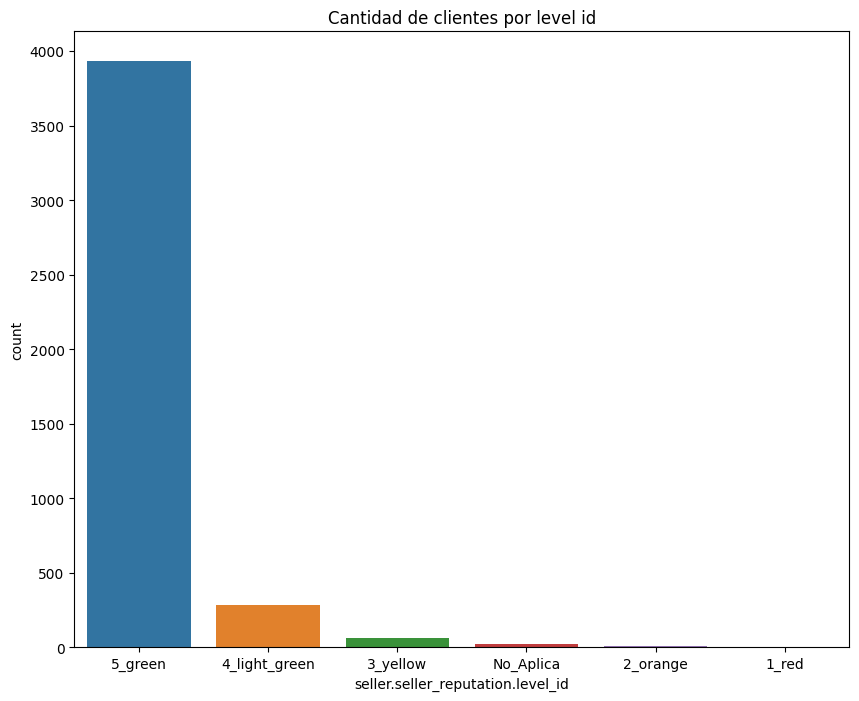

In [70]:
sns.countplot(x=df_final['seller.seller_reputation.level_id'],order=df_final['seller.seller_reputation.level_id'].value_counts().index)
plt.title("Cantidad de clientes por level id")

Cantidad de clientes por seller status

Text(0.5, 1.0, 'Cantidad de clientes por seller status')

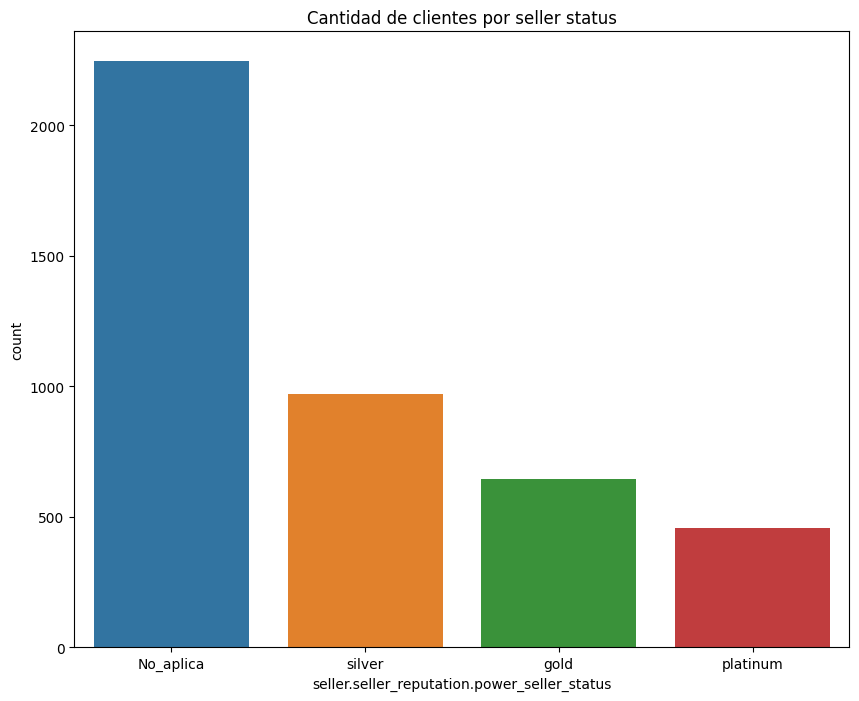

In [71]:
sns.countplot(x=df_final['seller.seller_reputation.power_seller_status'],order=df_final['seller.seller_reputation.power_seller_status'].value_counts().index)
plt.title("Cantidad de clientes por seller status")

Cantidad de clientes por state id

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 [Text(0, 0, 'CO-DC'),
  Text(1, 0, 'CO-ANT'),
  Text(2, 0, 'CO-VAC'),
  Text(3, 0, 'CO-CUN'),
  Text(4, 0, 'CO-SAN'),
  Text(5, 0, 'CO-NSA'),
  Text(6, 0, 'CO-ATL'),
  Text(7, 0, 'CO-RIS'),
  Text(8, 0, 'CN-GD'),
  Text(9, 0, 'CO-TOL'),
  Text(10, 0, 'CO-BOY'),
  Text(11, 0, 'CO-CAL'),
  Text(12, 0, 'CO-CES'),
  Text(13, 0, 'CO-NAR'),
  Text(14, 0, 'CO-HUI'),
  Text(15, 0, 'CO-QUI'),
  Text(16, 0, 'CO-BOL'),
  Text(17, 0, 'CO-MET'),
  Text(18, 0, 'CO-MAG'),
  Text(19, 0, 'CO-CAU'),
  Text(20, 0, 'CO-LAG'),
  Text(21, 0, 'CO-SUC'),
  Text(22, 0, 'CO-COR'),
  Text(23, 0, 'US-FL'),
  Text(24, 0, 'CN-ZJ'),
  Text(25, 0, 'CO-CAS'),
  Text(26, 0, 'CN-HA'),
  Text(27, 0, 'CN-FJ'),
  Text(28, 0, 'CN-SD'),
  Text(29, 0, 'CN-SC'),
  Text(30, 0, 'CN-JS'),
  Text(31, 0, 'CN-SH'),
  

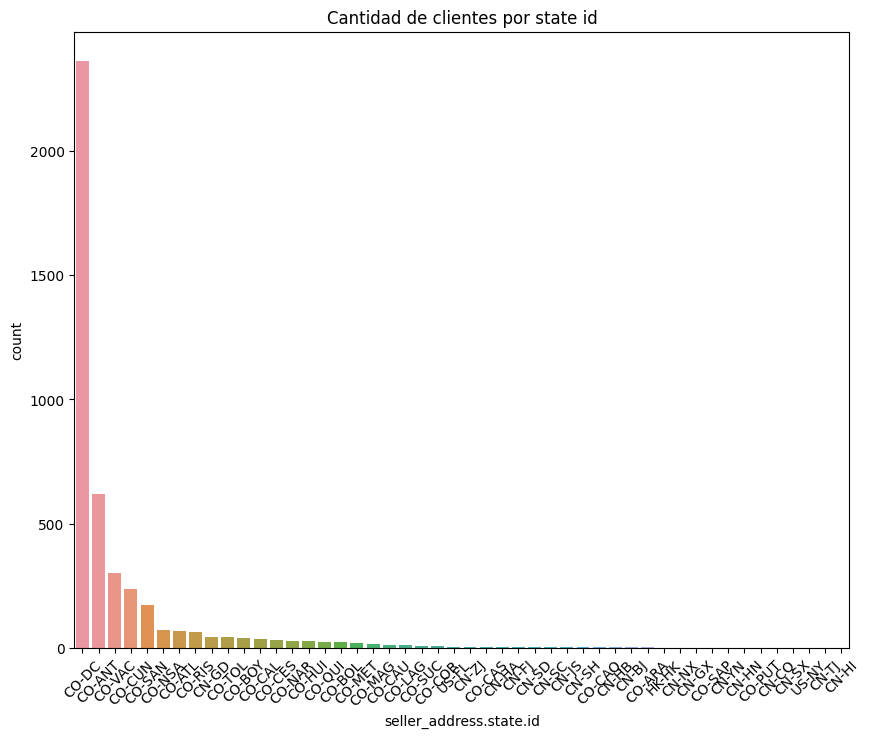

In [72]:
sns.countplot(x=df_final['seller_address.state.id'],order=df_final['seller_address.state.id'].value_counts().index)
plt.title("Cantidad de clientes por state id")
plt.xticks(rotation=45)

### *Histograma variables numéricas*

Precio

Text(0.5, 1.0, 'Histograma de precios')

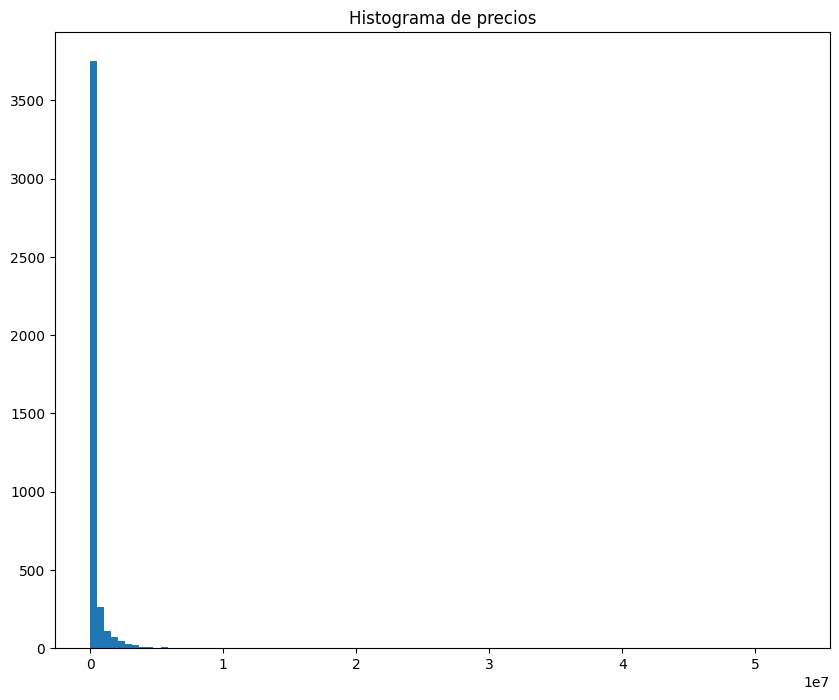

In [73]:
plt.hist(df_final['price'],bins=100)
plt.title("Histograma de precios")

Histograma de cantidades vendidas

Text(0.5, 1.0, 'Histograma de cantidades vendidas')

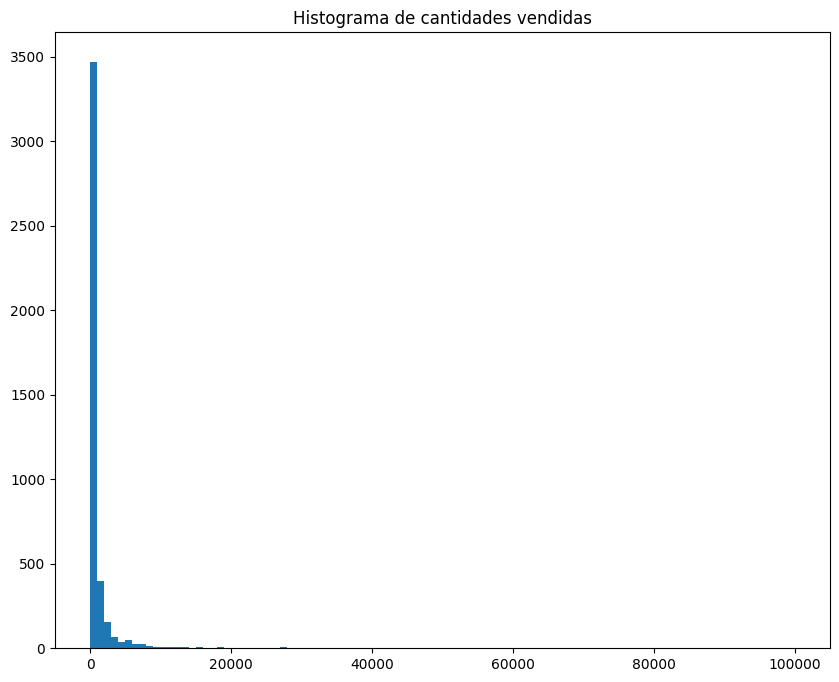

In [74]:
plt.hist(df_final['Sold_qty_tot'],bins=100)
plt.title("Histograma de cantidades vendidas")

Cantidades disponibles

Text(0.5, 1.0, 'Histograma de cantidades disponibles')

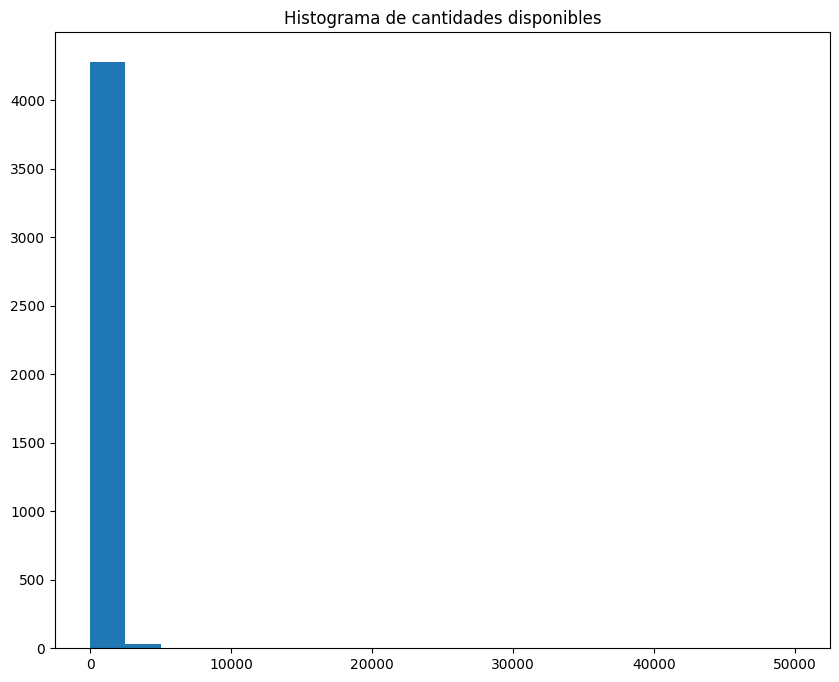

In [75]:
plt.hist(df_final['available_quantity'],bins=20)
plt.title("Histograma de cantidades disponibles")

Histograma de Transacciones canceladas

Text(0.5, 1.0, 'Histograma de Transacciones canceladas')

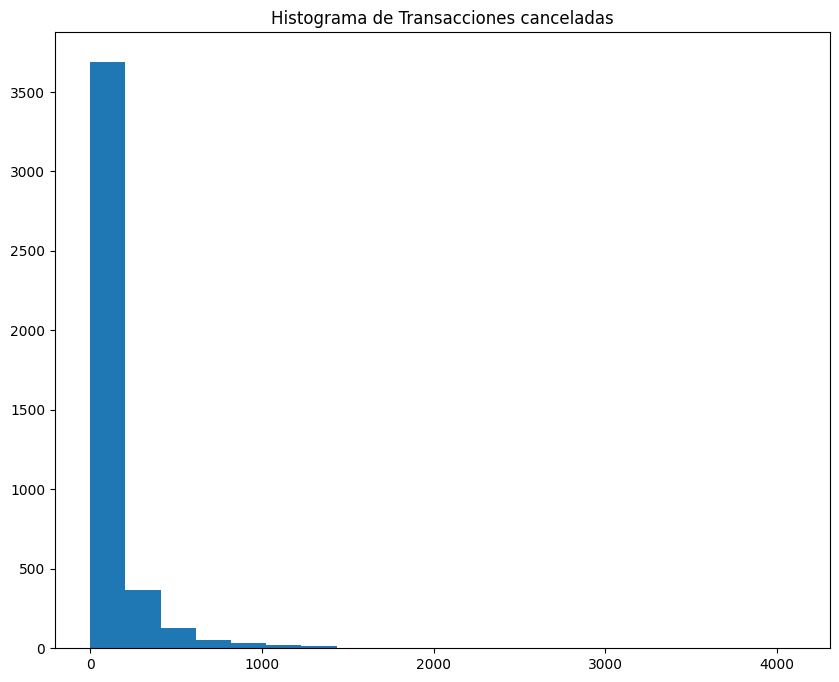

In [76]:
plt.hist(df_final['seller.seller_reputation.transactions.canceled'],bins=20)
plt.title("Histograma de Transacciones canceladas")

Histograma de Transacciones Completadas

Text(0.5, 1.0, 'Histograma de Transacciones Completadas')

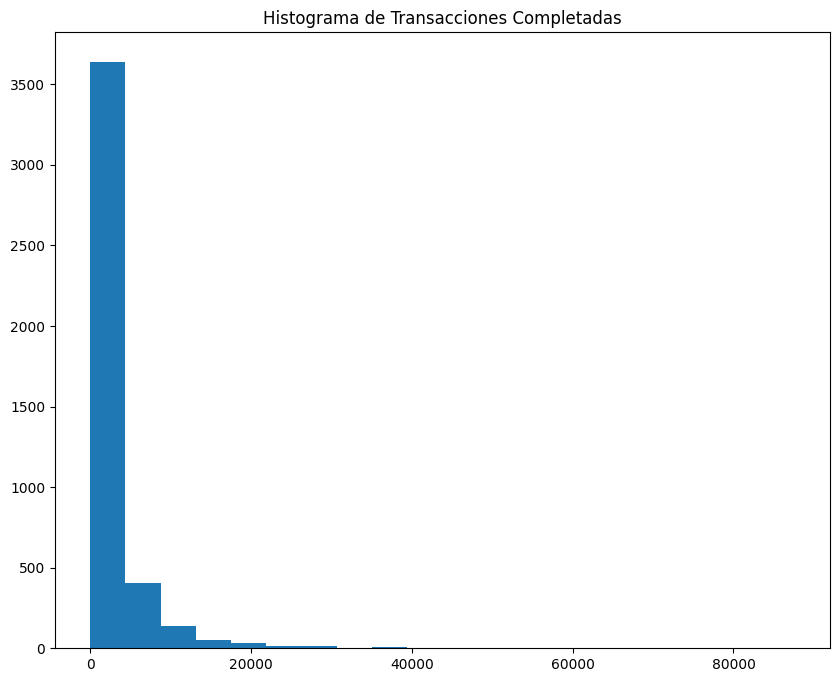

In [77]:
plt.hist(df_final['seller.seller_reputation.transactions.completed'],bins=20)
plt.title("Histograma de Transacciones Completadas")

Histograma de Rating Negativo

Text(0.5, 1.0, 'Histograma de Rating Negativo')

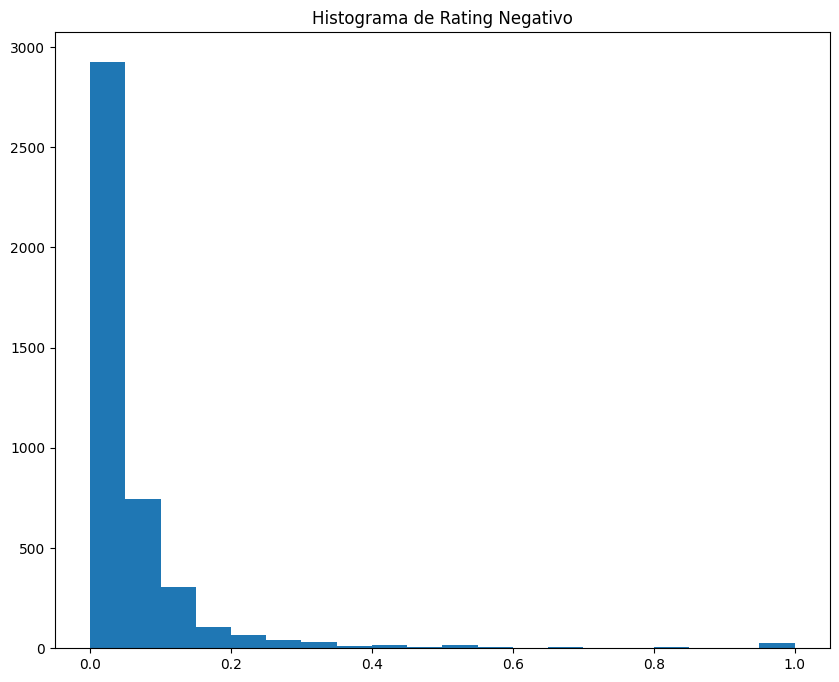

In [78]:
plt.hist(df_final['seller.seller_reputation.transactions.ratings.negative'],bins=20)
plt.title("Histograma de Rating Negativo")

Histograma de Rating Neutral

Text(0.5, 1.0, 'Histograma de Rating Neutral')

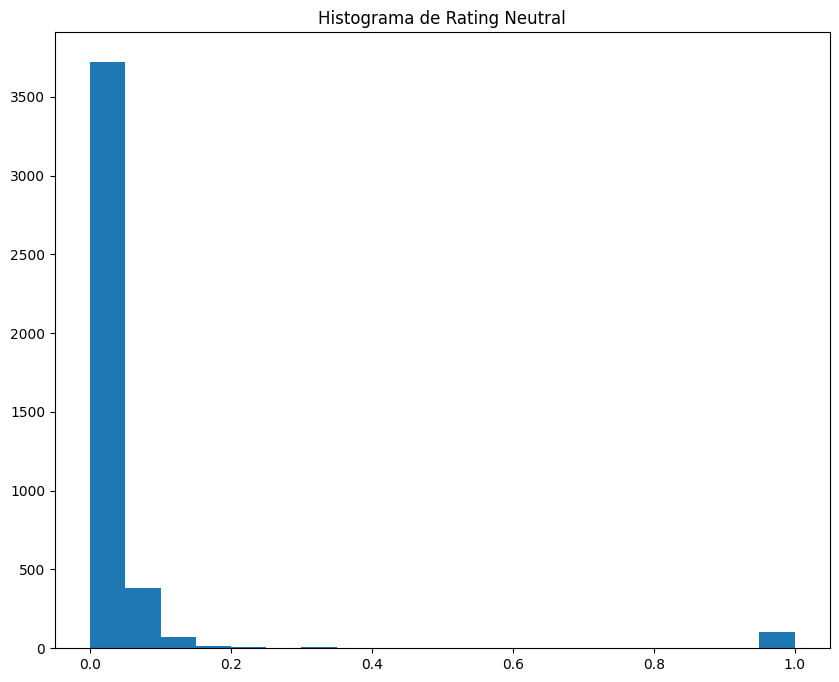

In [79]:
plt.hist(df_final['seller.seller_reputation.transactions.ratings.neutral'],bins=20)
plt.title("Histograma de Rating Neutral")

Histograma de Rating Positivo

Text(0.5, 1.0, 'Histograma de Rating Positivo')

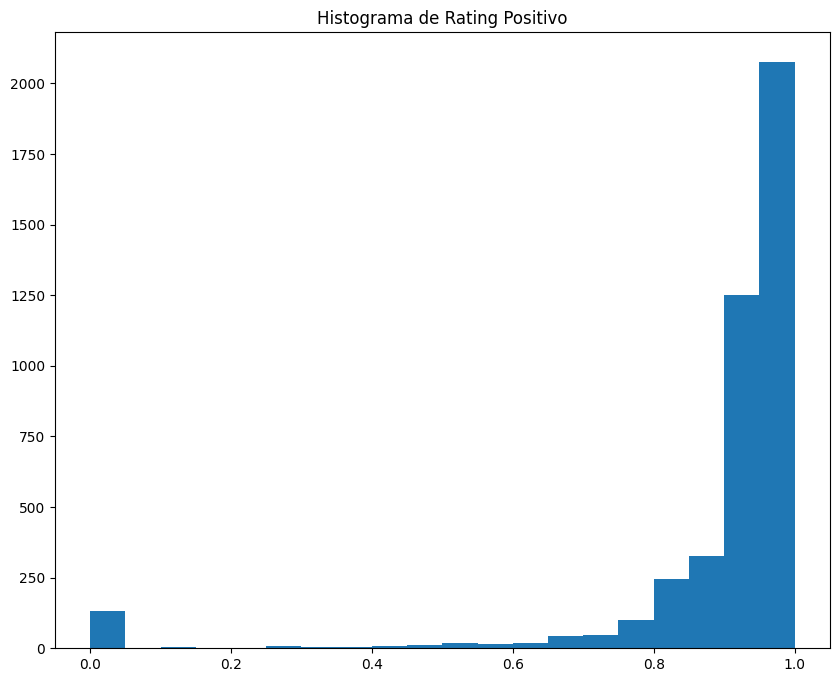

In [80]:
plt.hist(df_final['seller.seller_reputation.transactions.ratings.positive'],bins=20)
plt.title("Histograma de Rating Positivo")

Histograma de Transacciones Totales

Text(0.5, 1.0, 'Histograma de Transacciones Totales')

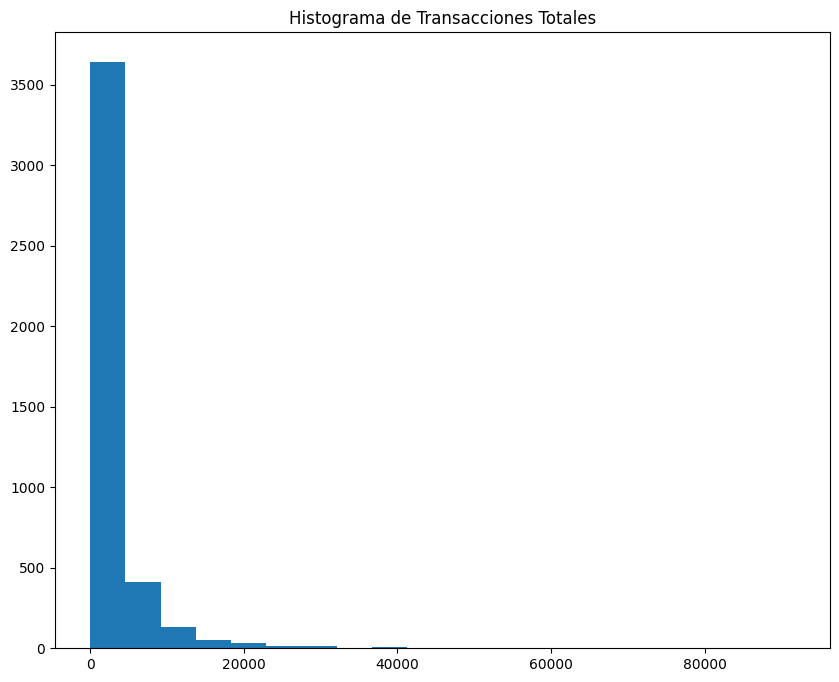

In [81]:
plt.hist(df_final['seller.seller_reputation.transactions.total'],bins=20)
plt.title("Histograma de Transacciones Totales")

Ventas Completadas

Text(0.5, 1.0, 'Histograma de Ventas Completadas')

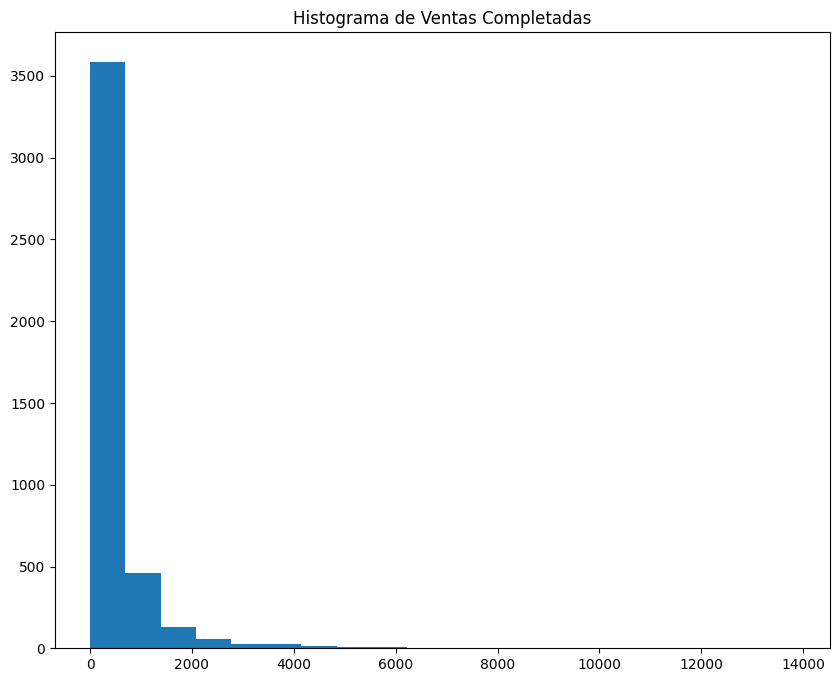

In [82]:
plt.hist(df_final['seller.seller_reputation.metrics.sales.completed'],bins=20)
plt.title("Histograma de Ventas Completadas")

Histograma de Claim Rate

Text(0.5, 1.0, 'Histograma de Claim Rate')

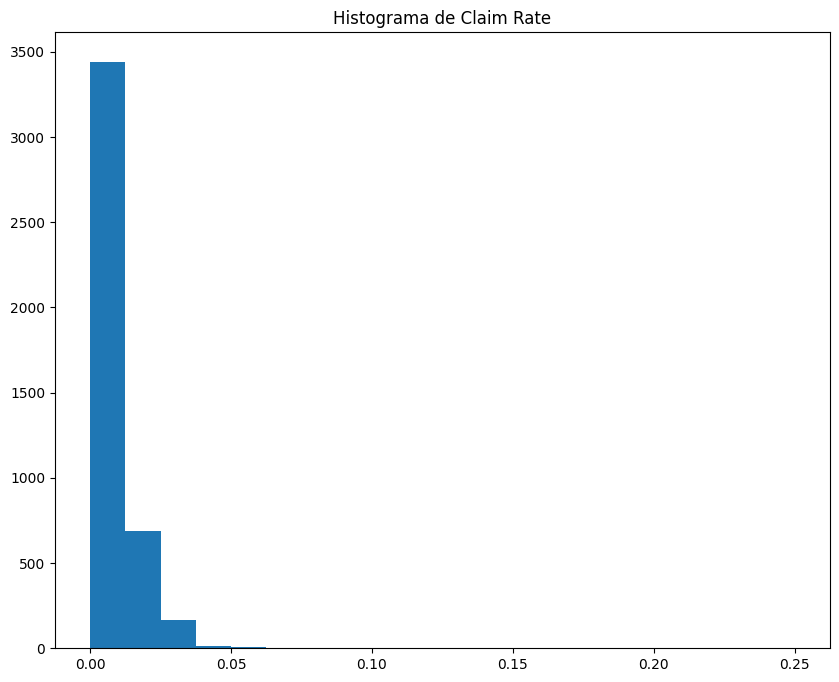

In [83]:
plt.hist(df_final['seller.seller_reputation.metrics.claims.rate'],bins=20)
plt.title("Histograma de Claim Rate")

Histograma de Claim Value

Text(0.5, 1.0, 'Histograma de Claim Value')

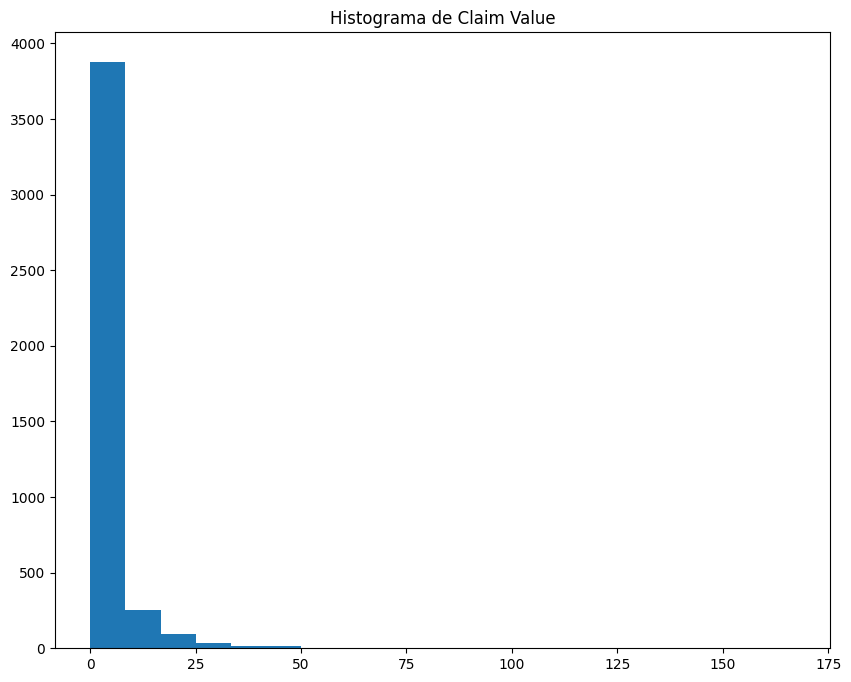

In [84]:
plt.hist(df_final['seller.seller_reputation.metrics.claims.value'],bins=20)
plt.title("Histograma de Claim Value")

Histograma de Rate Tiempo de Manejo

Text(0.5, 1.0, 'Histograma de Rate Tiempo de Manejo')

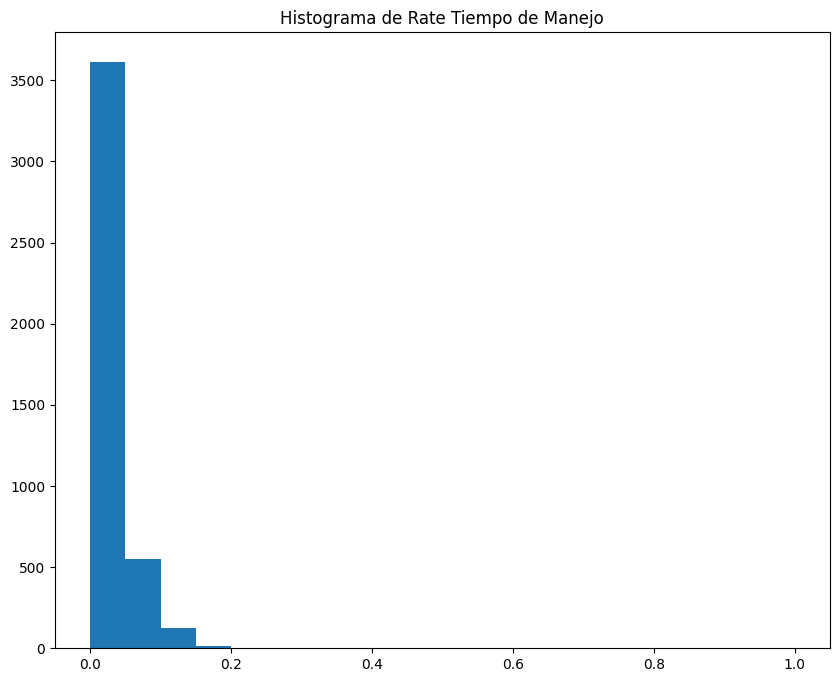

In [85]:
plt.hist(df_final['seller.seller_reputation.metrics.delayed_handling_time.rate'],bins=20)
plt.title("Histograma de Rate Tiempo de Manejo")

Histograma de Valor Tiempo de Manejo

Text(0.5, 1.0, 'Histograma de Valor Tiempo de Manejo')

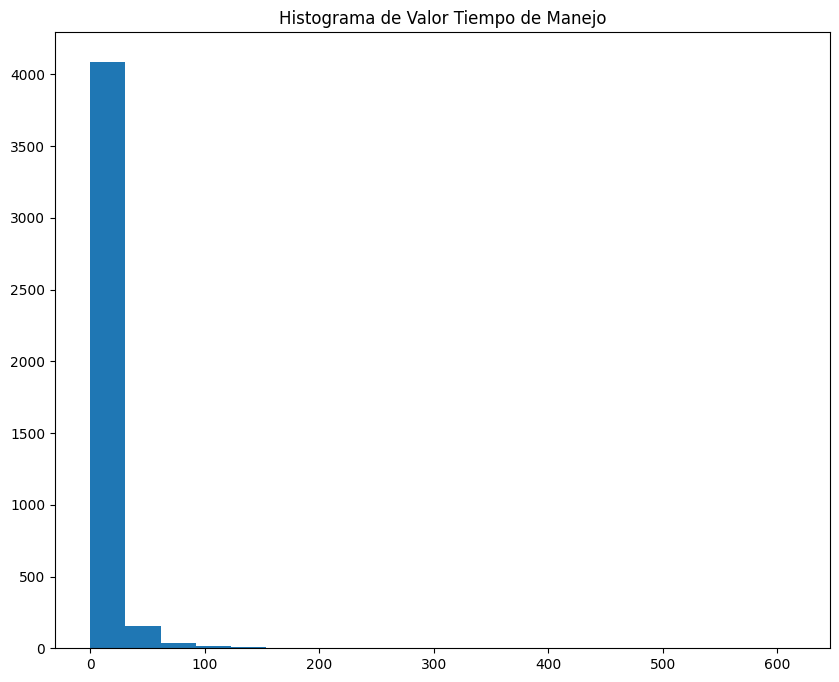

In [86]:
plt.hist(df_final['seller.seller_reputation.metrics.delayed_handling_time.value'],bins=20)
plt.title("Histograma de Valor Tiempo de Manejo")

Histograma de Tasa de Cancelación

Text(0.5, 1.0, 'Histograma de Tasa de Cancelación')

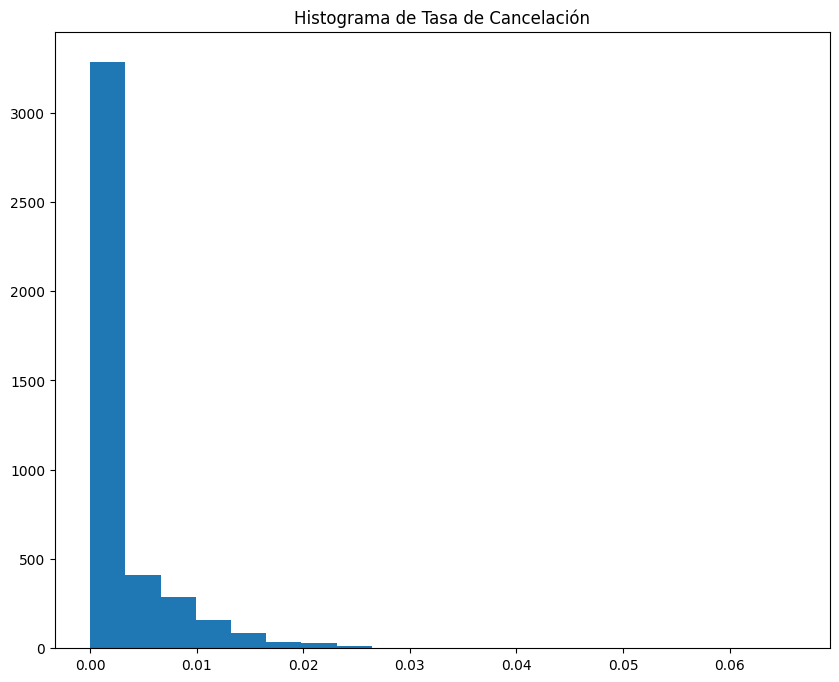

In [87]:
plt.hist(df_final['seller.seller_reputation.metrics.cancellations.rate'],bins=20)
plt.title("Histograma de Tasa de Cancelación")

Histograma de Valor de Cancelación

Text(0.5, 1.0, 'Histograma de Valor de Cancelación')

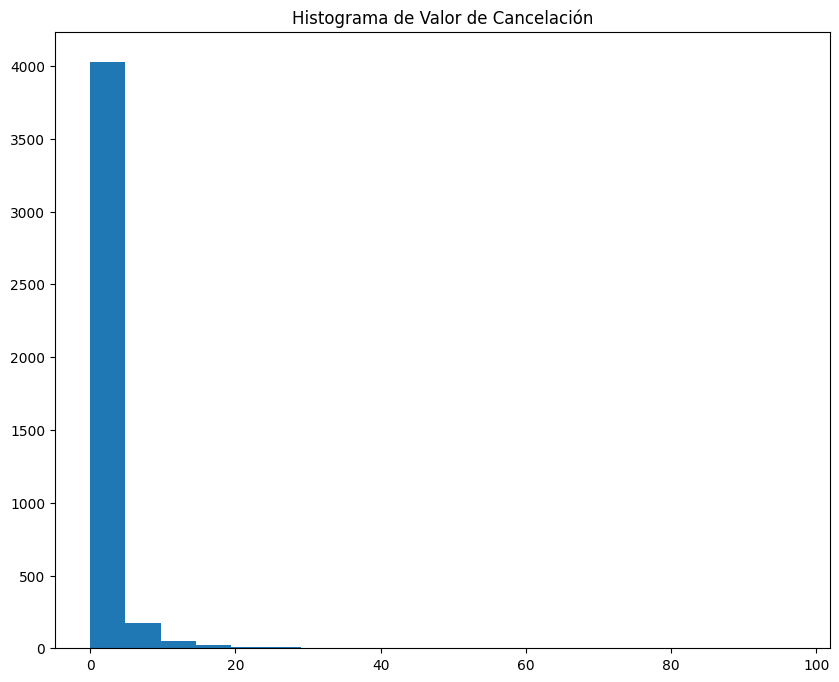

In [88]:
plt.hist(df_final['seller.seller_reputation.metrics.cancellations.value'],bins=20)
plt.title("Histograma de Valor de Cancelación")

Histograma de Dias desde registro

Text(0.5, 1.0, 'Histograma de Dias desde registro')

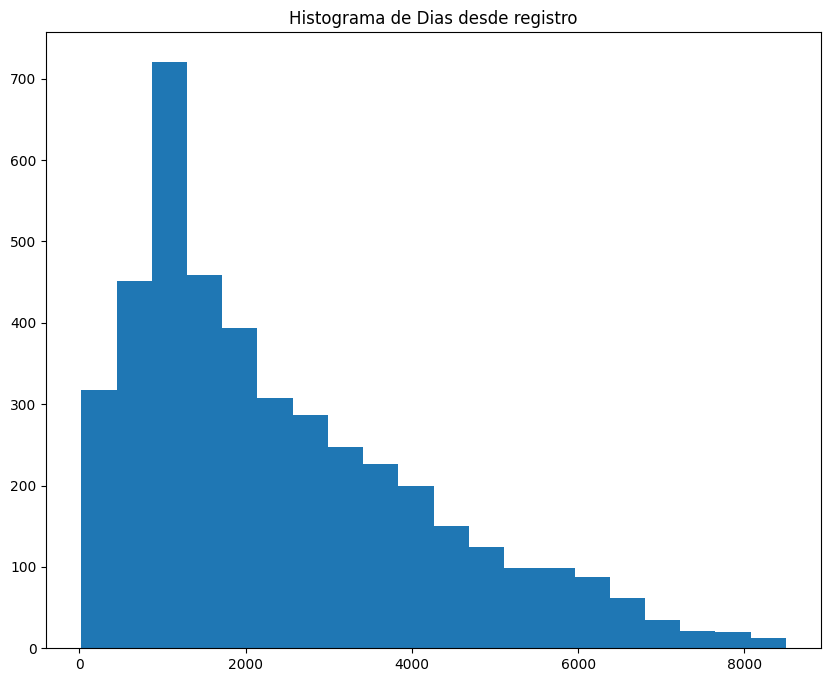

In [89]:
plt.hist(df_final['Dias_Usuario'],bins=20)
plt.title("Histograma de Dias desde registro")

Histograma de Utilidad Usuarios

Text(0.5, 1.0, 'Histograma de Utilidad Usuarios')

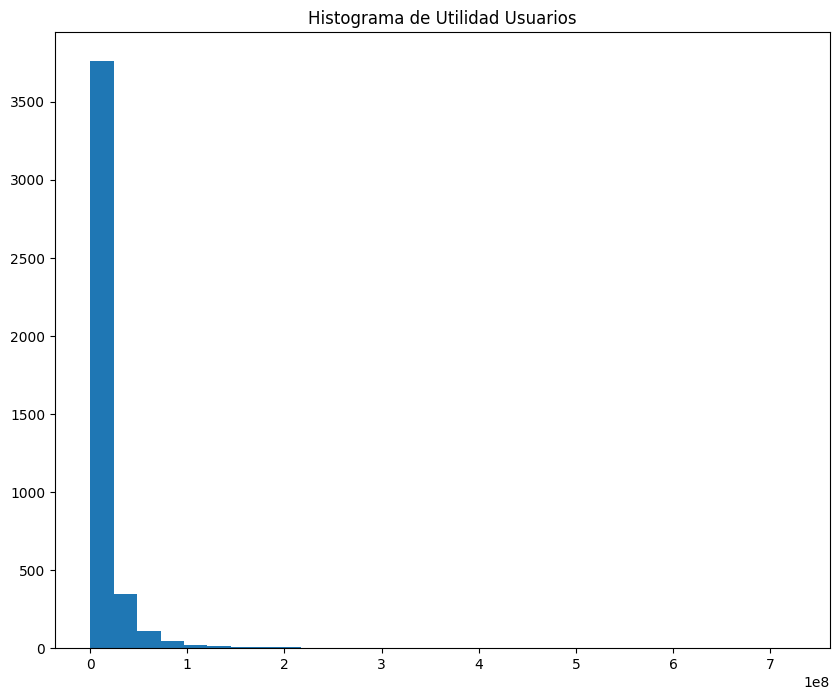

In [90]:
plt.hist(df_final['Utilidad_Generada'],bins=30)
plt.title("Histograma de Utilidad Usuarios")

Histograma de Cantidad de Productos a la venta

Text(0.5, 1.0, 'Histograma de Cantidad de Productos a la venta')

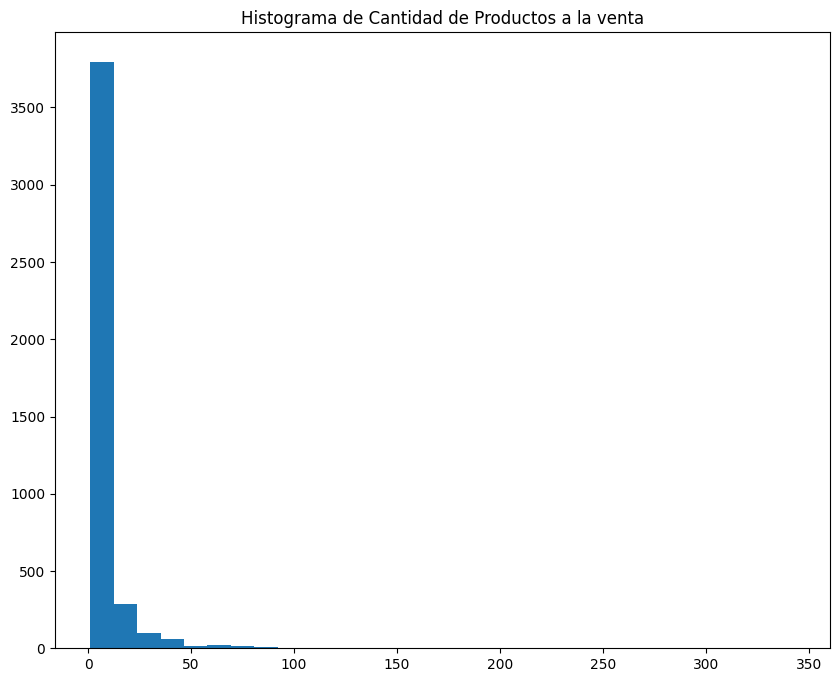

In [91]:
plt.hist(df_final['Cantidad_Prod_Vendiendo'],bins=30)
plt.title("Histograma de Cantidad de Productos a la venta")

## ***Análisis Bivariado***

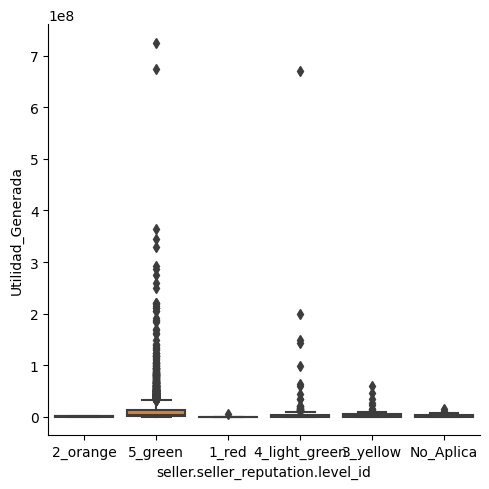

In [7]:
sns.catplot(data=df_final, x="seller.seller_reputation.level_id", y="Utilidad_Generada", kind="box")

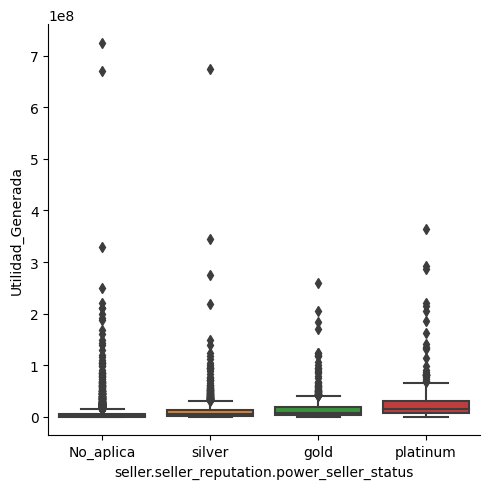

In [8]:
sns.catplot(data=df_final, x="seller.seller_reputation.power_seller_status", y="Utilidad_Generada", kind="box")

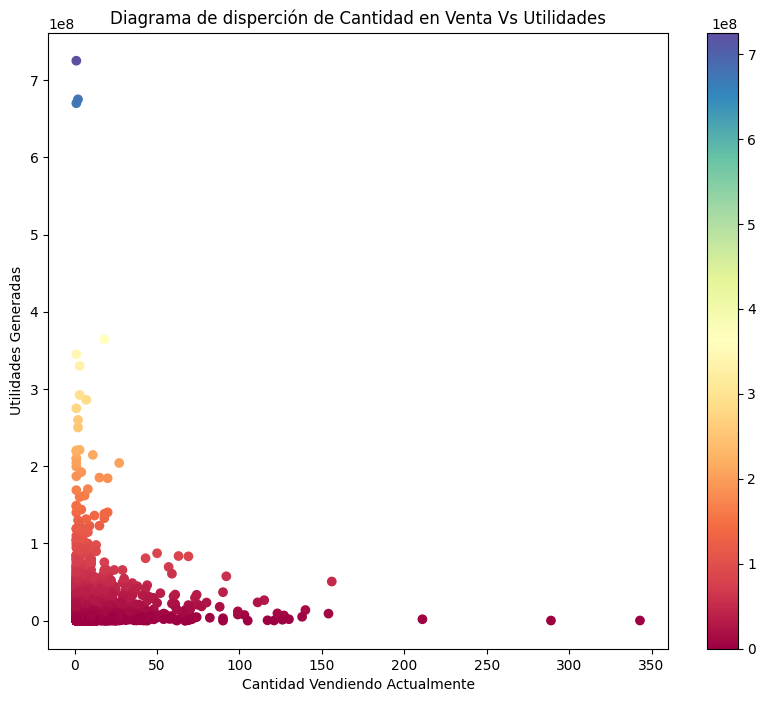

In [9]:
x = df_final['Cantidad_Prod_Vendiendo']
y = df_final['Utilidad_Generada']
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y, c=y, cmap='Spectral')
plt.colorbar()
plt.title('Diagrama de disperción de Cantidad en Venta Vs Utilidades')
plt.xlabel('Cantidad Vendiendo Actualmente')
plt.ylabel('Utilidades Generadas')
plt.show()

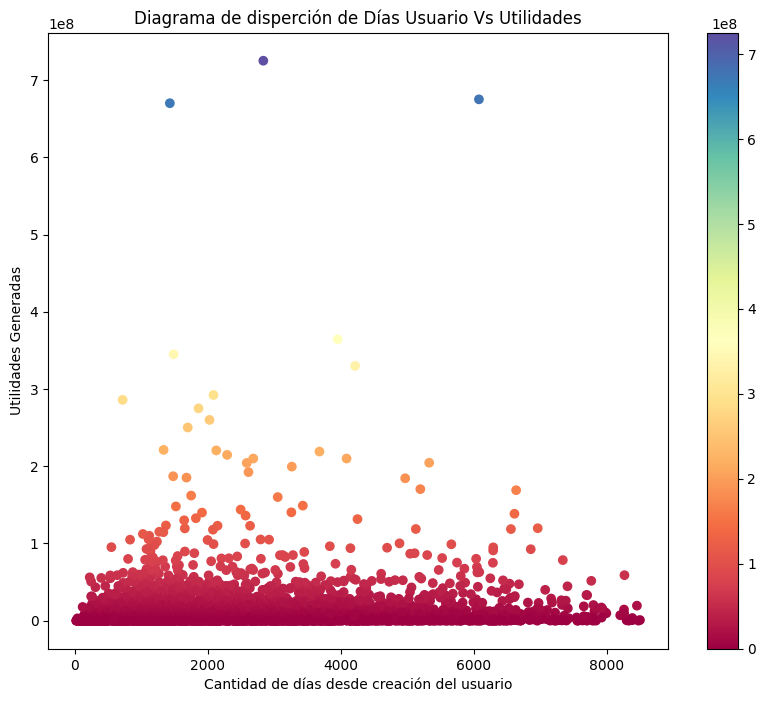

In [10]:
x = df_final['Dias_Usuario']
y = df_final['Utilidad_Generada']
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y, c=y, cmap='Spectral')
plt.colorbar()
plt.title('Diagrama de disperción de Días Usuario Vs Utilidades')
plt.xlabel('Cantidad de días desde creación del usuario')
plt.ylabel('Utilidades Generadas')
plt.show()

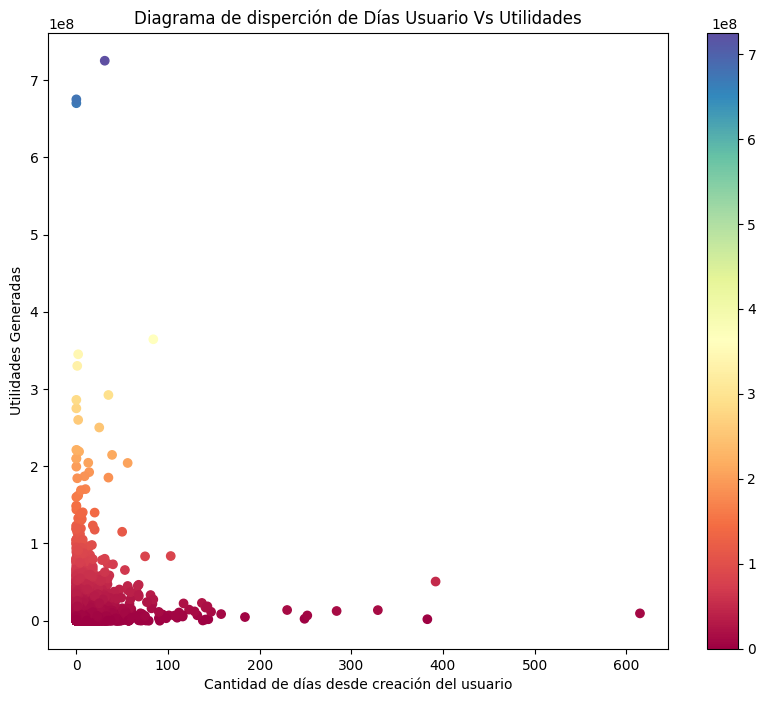

In [12]:
x = df_final['seller.seller_reputation.metrics.delayed_handling_time.value']
y = df_final['Utilidad_Generada']
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
plt.scatter(x, y, c=y, cmap='Spectral')
plt.colorbar()
plt.title('Diagrama de disperción de Días Usuario Vs Utilidades')
plt.xlabel('Cantidad de días desde creación del usuario')
plt.ylabel('Utilidades Generadas')
plt.show()

# **Preparación de la data**

En la siguiente sección se realiza la preparación final de la data para poder ser ingresada en el algoritmo

In [96]:
df_modelo = df_final.copy()

## *Eliminar variables que son explicadas con otras*

Se eliminan las variables que hacen que se genere un porcentaje del 100%

Después de revisar la parte analítica univariada se procede a borrar dos variables: 
- Transacciones canceladas que son descritas con las completas y totales 
- Rating neutral que puede ser explicado con bueno y malo

Referente a la ubicación es eliminada para que el algoritmo de cluster no sesgue a la persona por donde se encuentra

In [97]:
del df_modelo['seller.id'], df_modelo['seller.seller_reputation.transactions.canceled'], df_modelo['seller.seller_reputation.transactions.ratings.neutral'], df_modelo['seller_address.state.id']

## *Transformación a Dummies*

Se pasan las variables categóricas a valores binarios

In [98]:
categoricas = df_modelo.select_dtypes(exclude = [int, float]).columns #Trae todos los valores que no sean numéricos

In [99]:
len(df_modelo.columns) #Contar cantidad de columnas inicialmente

19

In [100]:
df_modelo= pd.get_dummies(df_modelo, columns = categoricas,drop_first=True) #Generación de Dummies

In [101]:
len(df_modelo.columns) #Contar cantidad de columnas después de la dummificación

25

## *Reducción de atípicos*

Se saca logaritmo natural para reducir un poco el tema de los atípicos

In [102]:
df_modelo=np.log1p(df_modelo) #se calcula logaritmo natural más 1 para evitar problemas con los ceros
df_modelo.head()

,price,Sold_qty_tot,available_quantity,seller.seller_reputation.transactions.completed,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.total,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,...,Utilidad_Generada,Cantidad_Prod_Vendiendo,seller.seller_reputation.level_id_2_orange,seller.seller_reputation.level_id_3_yellow,seller.seller_reputation.level_id_4_light_green,seller.seller_reputation.level_id_5_green,seller.seller_reputation.level_id_No_Aplica,seller.seller_reputation.power_seller_status_gold,seller.seller_reputation.power_seller_status_platinum,seller.seller_reputation.power_seller_status_silver
0,10.498967,1.791759,0.693147,3.988984,0.000000,0.693147,4.094345,3.988984,0.065507,1.609438,...,12.108383,0.693147,0.693359,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
1,10.645777,7.139660,4.335983,7.062192,0.131028,0.609766,7.118826,5.505332,0.015480,1.609438,...,15.112344,2.397895,0.000000,0.0,0.0,0.693359,0.0,0.0,0.0,0.693359
2,11.002117,6.216606,0.693147,6.638568,0.000000,0.693147,6.655440,4.454347,0.000000,0.000000,...,17.216708,0.693147,0.000000,0.0,0.0,0.693359,0.0,0.0,0.0,0.000000
3,10.473559,6.493754,4.164725,7.483807,0.009950,0.688135,7.508787,6.364751,0.003295,1.098612,...,14.986599,2.197225,0.000000,0.0,0.0,0.693359,0.0,0.0,0.0,0.693359
4,13.397626,2.708050,0.693147,5.720312,0.000000,0.693147,5.743003,4.290459,0.000000,0.000000,...,14.659742,1.609438,0.000000,0.0,0.0,0.693359,0.0,0.0,0.0,0.000000


## *Estandarización de la data*

Para aplicar de forma óptima la distancia se procede a realizar estandarización de la data

In [103]:
scaler = StandardScaler() #estandarizador

scaler.fit(df_modelo) #Se realiza estandarización
df_modelo = pd.DataFrame(scaler.transform(df_modelo), columns = df_modelo.columns) #Se transforma
df_modelo.head()

,price,Sold_qty_tot,available_quantity,seller.seller_reputation.transactions.completed,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.total,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,...,Utilidad_Generada,Cantidad_Prod_Vendiendo,seller.seller_reputation.level_id_2_orange,seller.seller_reputation.level_id_3_yellow,seller.seller_reputation.level_id_4_light_green,seller.seller_reputation.level_id_5_green,seller.seller_reputation.level_id_No_Aplica,seller.seller_reputation.power_seller_status_gold,seller.seller_reputation.power_seller_status_platinum,seller.seller_reputation.power_seller_status_silver
0,-0.755090,-1.153637,-0.738913,-1.593913,-0.571475,0.466841,-1.571912,-1.276595,6.080696,0.727747,...,-0.594802,-0.874172,23.213681,-0.123611,-0.264299,-3.201155,-0.074752,-0.419378,-0.343574,-0.538181
1,-0.648137,1.031618,1.047287,0.209481,0.924128,-0.197042,0.213203,0.028671,0.909890,0.727747,...,0.218110,1.064336,-0.043078,-0.123611,-0.264299,0.312387,-0.074752,-0.419378,-0.343574,1.858111
2,-0.388539,0.654440,-0.738913,-0.039107,-0.571475,0.466841,-0.060297,-0.876012,-0.690076,-0.960936,...,0.787579,-0.874172,-0.043078,-0.123611,-0.264299,0.312387,-0.074752,-0.419378,-0.343574,-0.538181
3,-0.773600,0.767688,0.963314,0.456889,-0.457898,0.426931,0.443367,0.768455,-0.349550,0.191770,...,0.184082,0.836149,-0.043078,-0.123611,-0.264299,0.312387,-0.074752,-0.419378,-0.343574,1.858111
4,1.356621,-0.779223,-0.738913,-0.577950,-0.571475,0.466841,-0.598838,-1.017086,-0.690076,-0.960936,...,0.095630,0.167763,-0.043078,-0.123611,-0.264299,0.312387,-0.074752,-0.419378,-0.343574,-0.538181


# **Modelamiento**

Se realizan los algoritmos con los cuales se dará solución al problema planteado

## ***K-Means***

Algoritmo de clustering tradicional que a partir de centroides identifica la distribución para poder seleccionar la cantidad de clusters necesarios

Se procede a generar una función que iterará sobre el número de clusters

In [104]:
def Seleccion_Mejor_Cluster(df, max_K):
    
    centroides = []
    k_resul = []
    silueta = [] 
    calinski = [] 
    davies_bouldin = []
    
    for k in range(2, max_K+1):  
      kmeans_model = KMeans(n_clusters = k, random_state=42)
      kmeans_model.fit(df)

      centroides.append(kmeans_model.inertia_)
      k_resul.append(k)
      silueta.append(silhouette_score(df, kmeans_model.labels_))
      calinski.append(calinski_harabasz_score(df, kmeans_model.labels_))
      davies_bouldin.append(davies_bouldin_score(df, kmeans_model.labels_))
        
    
    return centroides, k_resul, silueta, calinski, davies_bouldin

Se ejecuta el código

In [105]:
centroides, k_resul, silueta, calinski, davies_bouldin = Seleccion_Mejor_Cluster(df_modelo, 20)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

### *Evaluación y selección del modelo*

Se realiza gráfico de codo

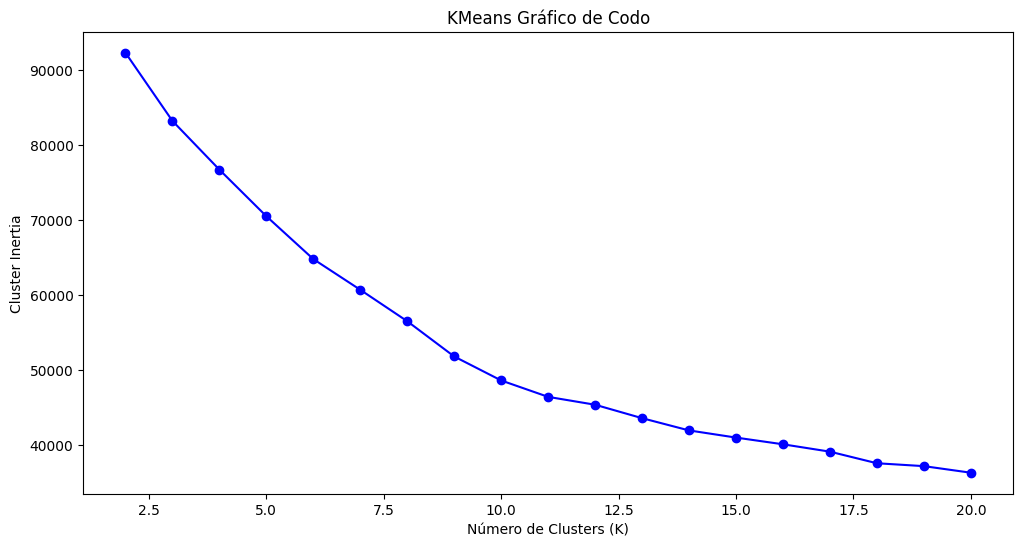

In [106]:
figure = plt.subplots(figsize = (12, 6))
plt.plot(k_resul, centroides, 'o-', color = 'blue')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Cluster Inertia")
plt.title("KMeans Gráfico de Codo")
plt.show()

Según gráfico de codo deberían ser entre 9 y 10 Cluster.

A continuación se revisa con el coeficiente de Silueta para poder corroborar la solución

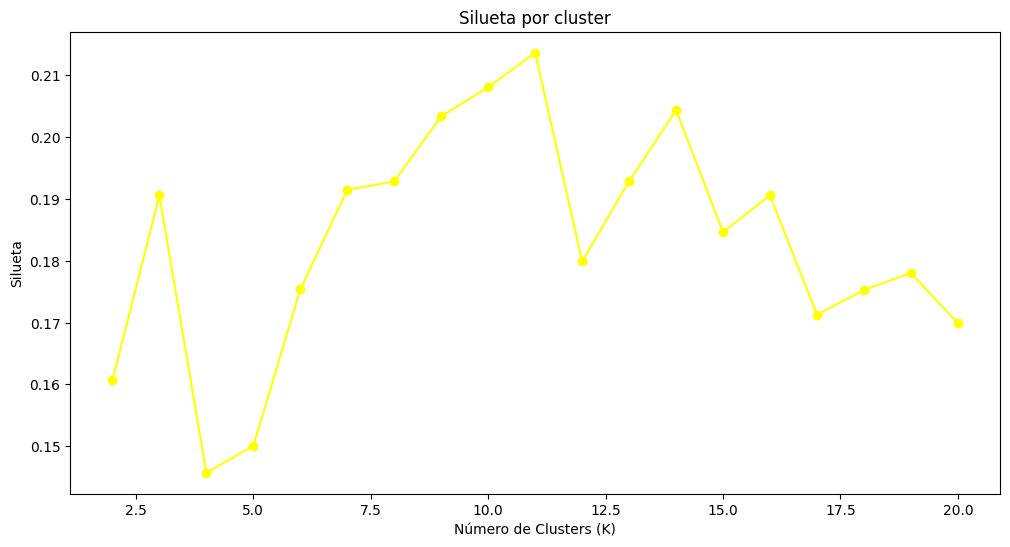

In [107]:
figure = plt.subplots(figsize = (12, 6))
plt.plot(k_resul, silueta, 'o-', color = 'yellow')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Silueta")
plt.title("Silueta por cluster")
plt.show()

Según el método de silueta el número que maxima es 12 clúster.

Se probará otra métrica para poder lograr un consenso en la solución.

A continuación se muestra el índice de Calinski, el cual se debe maximar

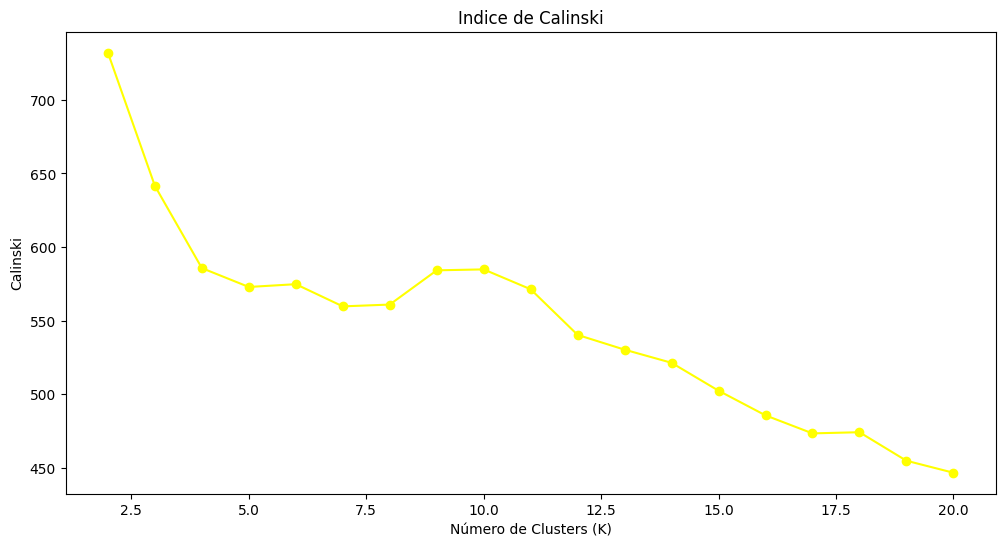

In [108]:
figure = plt.subplots(figsize = (12, 6))
plt.plot(k_resul, calinski, 'o-', color = 'yellow')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Calinski")
plt.title("Indice de Calinski")
plt.show()

El número de clúster que maximiza el índice son dos.

Por último se probará un último método de selección Davies-Bouldin. El cual se debe minimizar.

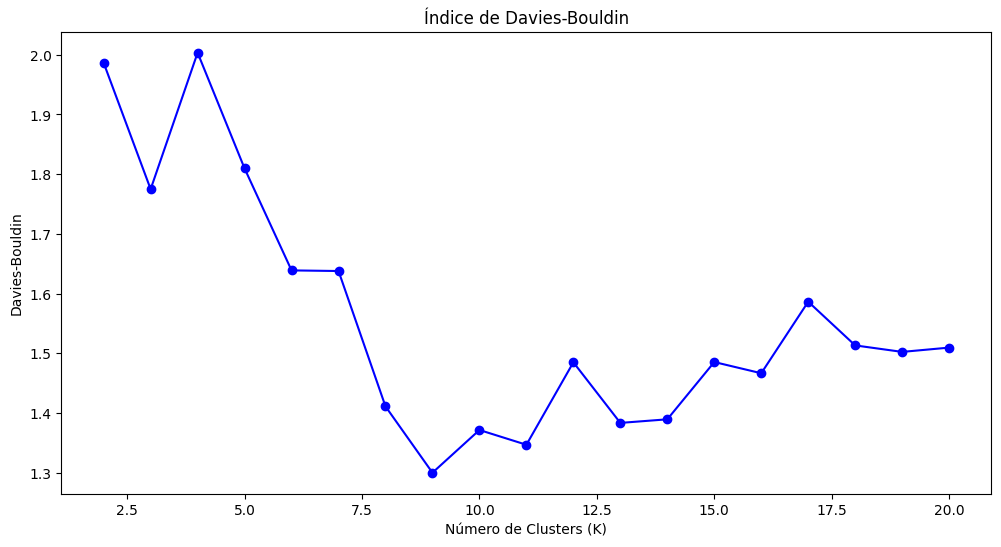

In [109]:
figure = plt.subplots(figsize = (12, 6))
plt.plot(k_resul, davies_bouldin, 'o-', color = 'blue')
plt.xlabel("Número de Clusters (K)")
plt.ylabel("Davies-Bouldin")
plt.title("Índice de Davies-Bouldin")
plt.show()

Aquí el número que minimiza son 9.

Por lo anterior y ya que dos modelos coinciden en la misma solución, se procede a seleccionar un k=9

### *Selección de mejor clúster*

Ahora se revisan los centroides para ver las variables más significativas

In [110]:
df_kmeans = df_modelo.copy()
columnas_graf = df_kmeans.columns
kmeans_model = KMeans(n_clusters = 10, random_state=42)
kmeans_model.fit(df_kmeans)
df_kmeans["clusters"] = kmeans_model.labels_
df_kmeans.head()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,price,Sold_qty_tot,available_quantity,seller.seller_reputation.transactions.completed,seller.seller_reputation.transactions.ratings.negative,seller.seller_reputation.transactions.ratings.positive,seller.seller_reputation.transactions.total,seller.seller_reputation.metrics.sales.completed,seller.seller_reputation.metrics.claims.rate,seller.seller_reputation.metrics.claims.value,...,Cantidad_Prod_Vendiendo,seller.seller_reputation.level_id_2_orange,seller.seller_reputation.level_id_3_yellow,seller.seller_reputation.level_id_4_light_green,seller.seller_reputation.level_id_5_green,seller.seller_reputation.level_id_No_Aplica,seller.seller_reputation.power_seller_status_gold,seller.seller_reputation.power_seller_status_platinum,seller.seller_reputation.power_seller_status_silver,clusters
0,-0.755090,-1.153637,-0.738913,-1.593913,-0.571475,0.466841,-1.571912,-1.276595,6.080696,0.727747,...,-0.874172,23.213681,-0.123611,-0.264299,-3.201155,-0.074752,-0.419378,-0.343574,-0.538181,4
1,-0.648137,1.031618,1.047287,0.209481,0.924128,-0.197042,0.213203,0.028671,0.909890,0.727747,...,1.064336,-0.043078,-0.123611,-0.264299,0.312387,-0.074752,-0.419378,-0.343574,1.858111,0
2,-0.388539,0.654440,-0.738913,-0.039107,-0.571475,0.466841,-0.060297,-0.876012,-0.690076,-0.960936,...,-0.874172,-0.043078,-0.123611,-0.264299,0.312387,-0.074752,-0.419378,-0.343574,-0.538181,9
3,-0.773600,0.767688,0.963314,0.456889,-0.457898,0.426931,0.443367,0.768455,-0.349550,0.191770,...,0.836149,-0.043078,-0.123611,-0.264299,0.312387,-0.074752,-0.419378,-0.343574,1.858111,0
4,1.356621,-0.779223,-0.738913,-0.577950,-0.571475,0.466841,-0.598838,-1.017086,-0.690076,-0.960936,...,0.167763,-0.043078,-0.123611,-0.264299,0.312387,-0.074752,-0.419378,-0.343574,-0.538181,9


Se observa qué variables son las más significativas para cada cluster a partir de su centroide

<Axes: >

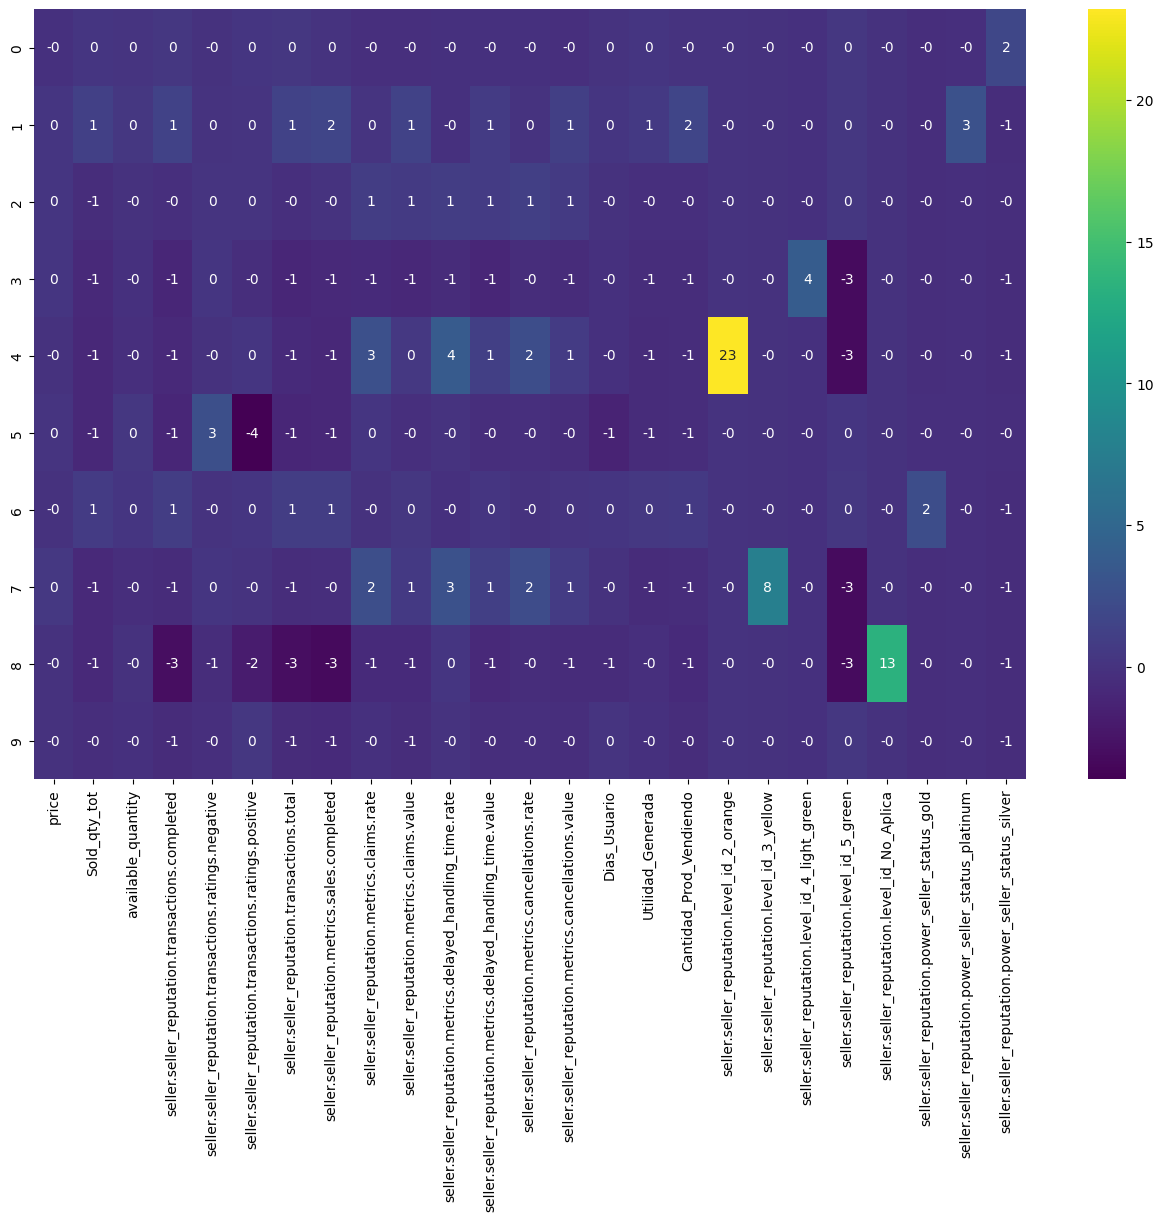

In [111]:
a= pd.DataFrame(kmeans_model.cluster_centers_, columns = columnas_graf)
plt.figure(figsize=(16, 10))
sns.heatmap(a, cmap='viridis', annot=True, fmt='.00f')


In [112]:
df_kmeans.groupby(['clusters'])['clusters'].count()

clusters
0     927
1     478
2     605
3     278
4       8
5     158
6     645
7      69
8      24
9    1127
Name: clusters, dtype: int64

## ***Fuzzy C-Means***

Algoritmo que mediante lógica Fuzzy ayuda a clusterizar

In [113]:
df_cmeans = df_modelo.copy()

Se emplea la misma cantidad de K que el generado por K-Means

In [114]:
my_model = FCM(n_clusters=10, m=4, random_state=42) # we use two cluster as an example
my_model.fit(df_cmeans.values) ## X, numpy array. rows:samples columns:features

In [115]:
centers = my_model.centers
labels = my_model.predict(df_cmeans.values)

Se observan los centros más importantes

<Axes: >

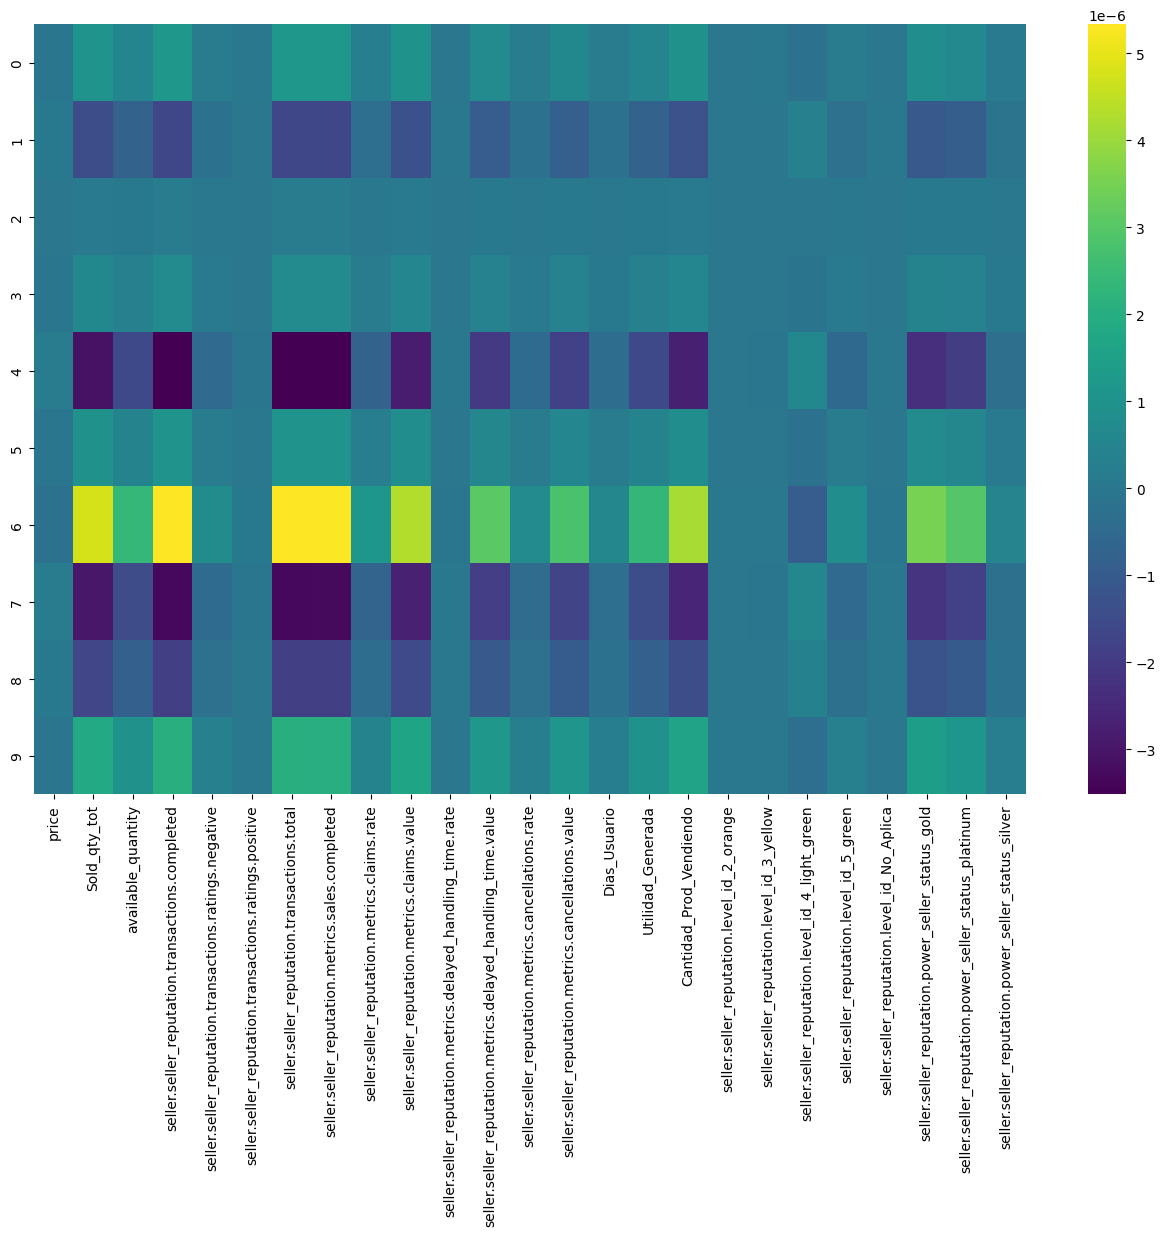

In [116]:
b= pd.DataFrame(centers, columns = columnas_graf)
plt.figure(figsize=(16, 10))
sns.heatmap(b, cmap='viridis')

Debido a que el método explicativo es más sencillo en el kmeans, se selecciona este modelo